Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# For this to work, use:
# Keras 2.3.1
# Also remember to use GPU in your colab notebook
%tensorflow_version 2.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1KL35Y4jz-za4VhiYyi9-wDsYb-_ES9Lg'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1IdJeCCcjeLt1H8vJNgWmgTFFfSnCUfZY'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1J4zNlfBAd1ng4GfyBabBM2EGjKreruBa'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '1k9ffQhdSi8nv1s9hV8jNBguR4m4FIZWp'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="latin1")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="latin1")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="latin1")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  2253
Number of dev sentences:  138
Number of test sentences:  182
Number of words in the training dataset:  5994
Number of words in the dev dataset:  1008
Number of words in the test dataset:  1171
Tags in the training dataset: ['I-Property-Unit', 'I-Nonrecipe-Material', 'B-Property-Misc', 'I-Characterization-Apparatus', 'I-Condition-Unit', 'B-Reference', 'I-Apparatus-Unit', 'I-Amount-Misc', 'I-Synthesis-Apparatus', 'B-Apparatus-Descriptor', 'I-Condition-Type', 'O', 'B-Condition-Misc', 'I-Property-Type', 'B-Characterization-Apparatus', 'B-Nonrecipe-Material', 'B-Property-Unit', 'B-Meta', 'I-Apparatus-Descriptor', 'I-Brand', 'B-Apparatus-Property-Type', 'I-Apparatus-Property-Type', 'I-Amount-Unit', 'B-Operation', 'I-Reference', 'B-Brand', 'I-Material-Descriptor', 'B-Amount-Unit', 'I-Property-Misc', 'B-Number', 'B-Synthesis-Apparatus', 'I-Number', 'B-Material-Descriptor', 'I-Material', 'B-Apparatus-Unit', 'B-Amount-Misc', 'I-Meta', 'B-Condition-Unit', 'B-Pr

,Sentence #,Word,Tag
0,Sentence: 1,10.1016,O
1,Sentence: 1,/,O
2,Sentence: 1,j.carbon.2014.03.017,O
3,Sentence: 2,High,B-Property-Misc
4,Sentence: 2,-,I-Property-Misc
5,Sentence: 2,capacity,I-Property-Misc
6,Sentence: 2,graphene,B-Material
7,Sentence: 2,oxide,I-Material
8,Sentence: 2,/,I-Material
9,Sentence: 2,graphite,I-Material


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #100 
training_sentences[100]

[('The', 'O'),
 ('obtained', 'O'),
 ('precursor', 'B-Material'),
 ('powder', 'B-Material-Descriptor'),
 ('was', 'O'),
 ('dried', 'B-Operation'),
 ('at', 'O'),
 ('120', 'B-Number'),
 ('degC', 'B-Condition-Unit'),
 ('for', 'O'),
 ('2', 'B-Number'),
 ('h', 'B-Condition-Unit'),
 ('and', 'O'),
 ('then', 'O'),
 ('calcined', 'B-Operation'),
 ('at', 'O'),
 ('700', 'B-Number'),
 ('degC', 'B-Condition-Unit'),
 ('for', 'O'),
 ('2', 'B-Number'),
 ('h', 'B-Condition-Unit'),
 ('.', 'O')]

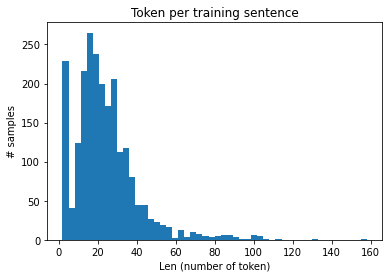

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

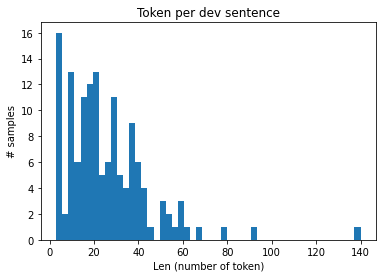

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

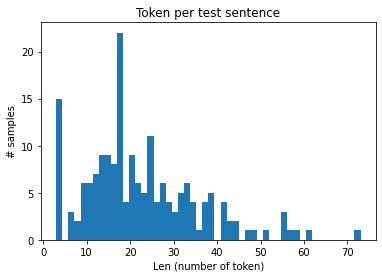

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'ethanol'
print(word2idx['ethanol'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-Material'
print(tag2idx['B-Material'])
# Tag of index 4
print(idx2tag[4])

2958
residual
42
I-Condition-Unit


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.9778)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 2253
Points in y_train before removal: 2253
Points in X_train before removal: 50
Points in y_train before removal: 50


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['ethanol'])
print(idx2word[10])
print(tag2idx['B-Material'])
print(idx2tag[4])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[3727, 2317, 1384, 2172, 3412, 3921, 2317, 5423, 2172, 3412, 1569, 5686, 4740, 2172, 3412, 3813, 6146, 157, 3905, 4466, 410, 4501, 410, 2988, 3967, 1341, 2659, 194, 3154, 4311, 4502, 2213, 5891, 5845, 5302]
[11, 11, 29, 27, 11, 42, 11, 29, 27, 11, 42, 11, 29, 27, 11, 42, 11, 11, 11, 29, 31, 31, 31, 31, 11, 11, 23, 11, 11, 42, 11, 11, 11, 23, 11]
[2413, 2704, 1835]
[11, 11, 11]
[2413, 2704, 980]
[11, 11, 11]
2958
residual
42
I-Condition-Unit
6535
43


In [1]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 2.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '1k9ffQhdSi8nv1s9hV8jNBguR4m4FIZWp'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['ethanol'])
print(idx2word[10])
print(tag2idx['B-Material'])
print(idx2tag[4])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 14.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 15.0 MB/s 
     |████████████████████████████████| 120 kB 48.1 MB/s 
     |████████████████████████████████| 6.6 MB 58.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.1 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=1917e73e185786ba06b2874bb710157cfe7cd935af341cc255a84f9703b7f29b
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
[3727, 2317, 1384, 2172, 3412, 3921, 2317, 5423, 2172, 341

In [2]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [3]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [4]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True,
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

In [5]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('allenai/scibert_scivocab_uncased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 32:
    TRAIN_BATCH_SIZE = 32
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 32:
    VALID_BATCH_SIZE = 32
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [6]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [7]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [8]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  augmented_X_train_words = [[idx2word[word] for word in sentence] for sentence in augmented_X_train]
  X_dev_words = [[idx2word[word] for word in sentence] for sentence in X_dev]
  X_test_words = [[idx2word[word] for word in sentence] for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [9]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.7556333541870117
Training loss epoch: 2.6758362293243407
Training accuracy epoch: 0.4190316150161042
Validating model...
Validation Loss: 1.846897268295288
Validation Accuracy: 0.5858737802085363
Training epoch: 2
Training loss per 100 training steps: 1.9469059705734253
Training loss epoch: 1.625831127166748
Training accuracy epoch: 0.635854877420278
Validating model...
Validation Loss: 1.3727346301078795
Validation Accuracy: 0.7242077956797774
Training epoch: 3
Training loss per 100 training steps: 1.1252232789993286
Training loss epoch: 1.1636189699172974
Training accuracy epoch: 0.7297477491432597
Validating model...
Validation Loss: 1.112804913520813
Validation Accuracy: 0.7452542201886491
Training epoch: 4
Training loss per 100 training steps: 0.9530523419380188
Training loss epoch: 0.8937214970588684
Training accuracy epoch: 0.7876790126951213
Validating model...
Validation Loss: 1.0182781755924224
Validation Accuracy: 0.7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8182217249503503
Validation Accuracy: 0.8058450197526545
Validation duration: 0.01865601666666663 minutes
F1-score (test): 64.5%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.58      0.81      0.68        98
      Apparatus-Descriptor       0.43      0.33      0.38         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.00      0.00      0.00        13
                     Brand       0.23      0.26      0.25        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.00      0.00      0.00        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.76      0.92      0.83        87
                  Material       0.51      0.80      0.63       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.707988977432251
Training loss epoch: 2.7346245765686037
Training accuracy epoch: 0.4184411719910145
Validating model...
Validation Loss: 1.8573226571083068
Validation Accuracy: 0.5832750655134271
Training epoch: 2
Training loss per 100 training steps: 1.8910061120986938
Training loss epoch: 1.5891374111175538
Training accuracy epoch: 0.6306216441492027
Validating model...
Validation Loss: 1.4141918540000915
Validation Accuracy: 0.724079706947858
Training epoch: 3
Training loss per 100 training steps: 1.4955776929855347
Training loss epoch: 1.1532070994377137
Training accuracy epoch: 0.7467748008354036
Validating model...
Validation Loss: 1.1405310451984405
Validation Accuracy: 0.7315899847266023
Training epoch: 4
Training loss per 100 training steps: 0.9762426614761353
Training loss epoch: 0.861621105670929
Training accuracy epoch: 0.7928893393597727
Validating model...
Validation Loss: 1.0203722357749938
Validation Accuracy: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.85892342374875
Validation Accuracy: 0.8044638340103722
Validation duration: 0.01871955000000014 minutes
F1-score (test): 65.7%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.55      0.83      0.66        98
      Apparatus-Descriptor       0.30      0.33      0.32         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.40      0.15      0.22        13
                     Brand       0.29      0.41      0.34        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.53      0.40      0.46        20
            Condition-Type       0.33      1.00      0.50         1
            Condition-Unit       0.73      0.93      0.82        87
                  Material       0.54      0.80      0.65       316
       Material-D

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.9707841873168945
Training loss epoch: 2.7812094688415527
Training accuracy epoch: 0.40359605998628334
Validating model...
Validation Loss: 1.831627321243286
Validation Accuracy: 0.5856056512489553
Training epoch: 2
Training loss per 100 training steps: 2.1976430416107178
Training loss epoch: 1.6546394586563111
Training accuracy epoch: 0.6306876085250603
Validating model...
Validation Loss: 1.426806128025055
Validation Accuracy: 0.7186769165634093
Training epoch: 3
Training loss per 100 training steps: 1.309861421585083
Training loss epoch: 1.2110743522644043
Training accuracy epoch: 0.7360490579589795
Validating model...
Validation Loss: 1.1377581179141998
Validation Accuracy: 0.7395213164553562
Training epoch: 4
Training loss per 100 training steps: 0.7485184073448181
Training loss epoch: 0.875283682346344
Training accuracy epoch: 0.7887407244863028
Validating model...
Validation Loss: 0.9836498916149139
Validation Accuracy: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.829976893388308
Validation Accuracy: 0.8034809908246566
Validation duration: 0.01875850000000009 minutes
F1-score (test): 64.7%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.58      0.82      0.68        98
      Apparatus-Descriptor       0.27      0.33      0.30         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.15      0.25        13
                     Brand       0.26      0.30      0.28        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.27      0.15      0.19        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.70      0.90      0.78        87
                  Material       0.53      0.80      0.64       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.8112711906433105
Training loss epoch: 2.6787708520889284
Training accuracy epoch: 0.4347249683791781
Validating model...
Validation Loss: 1.783746862411499
Validation Accuracy: 0.5867206587298487
Training epoch: 2
Training loss per 100 training steps: 1.7806288003921509
Training loss epoch: 1.5678913116455078
Training accuracy epoch: 0.634918986130758
Validating model...
Validation Loss: 1.3621851325035095
Validation Accuracy: 0.7272648464919759
Training epoch: 3
Training loss per 100 training steps: 1.3067322969436646
Training loss epoch: 1.1243321418762207
Training accuracy epoch: 0.766923010544534
Validating model...
Validation Loss: 1.0975512325763703
Validation Accuracy: 0.7522266159836615
Training epoch: 4
Training loss per 100 training steps: 0.7066174745559692
Training loss epoch: 0.8646118998527527
Training accuracy epoch: 0.7937576024131977
Validating model...
Validation Loss: 0.9858327567577362
Validation Accuracy: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.868273024375622
Validation Accuracy: 0.7975446605173853
Validation duration: 0.018810999999999942 minutes
F1-score (test): 63.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.63      0.87      0.73        98
      Apparatus-Descriptor       0.25      0.33      0.29         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.43      0.23      0.30        13
                     Brand       0.38      0.30      0.33        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.05      0.05      0.05        20
            Condition-Type       0.17      1.00      0.29         1
            Condition-Unit       0.70      0.87      0.78        87
                  Material       0.51      0.79      0.62       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.806410789489746
Training loss epoch: 2.6765387058258057
Training accuracy epoch: 0.4427733228281544
Validating model...
Validation Loss: 1.8153303027153016
Validation Accuracy: 0.5848441911732118
Training epoch: 2
Training loss per 100 training steps: 1.9290748834609985
Training loss epoch: 1.5668967962265015
Training accuracy epoch: 0.6303050044457275
Validating model...
Validation Loss: 1.3417815923690797
Validation Accuracy: 0.7378122748478535
Training epoch: 3
Training loss per 100 training steps: 1.0887596607208252
Training loss epoch: 1.1315775871276856
Training accuracy epoch: 0.7579527576247395
Validating model...
Validation Loss: 1.0726076543331147
Validation Accuracy: 0.7599235947739259
Training epoch: 4
Training loss per 100 training steps: 0.7439142465591431
Training loss epoch: 0.8592001438140869
Training accuracy epoch: 0.7865782461842761
Validating model...
Validation Loss: 0.9355851352214813
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8121580023031968
Validation Accuracy: 0.8022050098878164
Validation duration: 0.020189033333333366 minutes
F1-score (test): 63.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.51      0.80      0.62        98
      Apparatus-Descriptor       0.50      0.33      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.00      0.00      0.00        13
                     Brand       0.00      0.00      0.00        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.14      0.05      0.07        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.74      0.90      0.81        87
                  Material       0.49      0.81      0.61       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 4.211957931518555
Training loss epoch: 2.922151517868042
Training accuracy epoch: 0.38329701577550485
Validating model...
Validation Loss: 1.8444895148277283
Validation Accuracy: 0.5865678245953092
Training epoch: 2
Training loss per 100 training steps: 1.6836376190185547
Training loss epoch: 1.6078498840332032
Training accuracy epoch: 0.5950940838642316
Validating model...
Validation Loss: 1.4302915811538697
Validation Accuracy: 0.707406228176398
Training epoch: 3
Training loss per 100 training steps: 1.5020631551742554
Training loss epoch: 1.2139073133468627
Training accuracy epoch: 0.7441782935860045
Validating model...
Validation Loss: 1.14881032705307
Validation Accuracy: 0.7443502749995176
Training epoch: 4
Training loss per 100 training steps: 0.8261685967445374
Training loss epoch: 0.8911133646965027
Training accuracy epoch: 0.7914228612144198
Validating model...
Validation Loss: 1.0133193552494049
Validation Accuracy: 0.7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8393378051427695
Validation Accuracy: 0.8072932162968794
Validation duration: 0.018859250000000334 minutes
F1-score (test): 66.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.55      0.85      0.67        98
      Apparatus-Descriptor       0.31      0.44      0.36         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.80      0.31      0.44        13
                     Brand       0.21      0.41      0.28        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.82      0.70      0.76        20
            Condition-Type       0.50      1.00      0.67         1
            Condition-Unit       0.84      0.91      0.87        87
                  Material       0.59      0.83      0.69       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.7913413047790527
Training loss epoch: 2.5241811752319334
Training accuracy epoch: 0.4426852884115431
Validating model...
Validation Loss: 1.845636785030365
Validation Accuracy: 0.5777062053605537
Training epoch: 2
Training loss per 100 training steps: 2.057542085647583
Training loss epoch: 1.590858030319214
Training accuracy epoch: 0.6270548183425275
Validating model...
Validation Loss: 1.3403650999069214
Validation Accuracy: 0.7189404901935786
Training epoch: 3
Training loss per 100 training steps: 1.2395228147506714
Training loss epoch: 1.0890522718429565
Training accuracy epoch: 0.7569333736729661
Validating model...
Validation Loss: 1.0771371364593505
Validation Accuracy: 0.7542616469961386
Training epoch: 4
Training loss per 100 training steps: 0.827705442905426
Training loss epoch: 0.8174932956695556
Training accuracy epoch: 0.7936013111250572
Validating model...
Validation Loss: 0.9837709128856659
Validation Accuracy: 0.7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.830414001758282
Validation Accuracy: 0.8037126174932886
Validation duration: 0.018840883333334092 minutes
F1-score (test): 64.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.62      0.86      0.72        98
      Apparatus-Descriptor       0.43      0.33      0.38         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.08      0.13        13
                     Brand       0.32      0.26      0.29        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.00      0.00      0.00        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.71      0.92      0.80        87
                  Material       0.51      0.81      0.62       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.9336235523223877
Training loss epoch: 2.779626226425171
Training accuracy epoch: 0.40051425981497424
Validating model...
Validation Loss: 1.7654012203216554
Validation Accuracy: 0.5802543565028817
Training epoch: 2
Training loss per 100 training steps: 1.6557021141052246
Training loss epoch: 1.5877676486968995
Training accuracy epoch: 0.6246927012653959
Validating model...
Validation Loss: 1.3727664351463318
Validation Accuracy: 0.7207634922516851
Training epoch: 3
Training loss per 100 training steps: 1.5121937990188599
Training loss epoch: 1.1310323357582093
Training accuracy epoch: 0.7433147037994511
Validating model...
Validation Loss: 1.1123310267925262
Validation Accuracy: 0.750254147800692
Training epoch: 4
Training loss per 100 training steps: 1.059727430343628
Training loss epoch: 0.8605294466018677
Training accuracy epoch: 0.7900845116054007
Validating model...
Validation Loss: 0.9904963314533234
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8649628208233759
Validation Accuracy: 0.7908920527174337
Validation duration: 0.01893256666666616 minutes
F1-score (test): 63.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.60      0.84      0.70        98
      Apparatus-Descriptor       0.33      0.33      0.33         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.15      0.25        13
                     Brand       1.00      0.07      0.14        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.00      0.00      0.00        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.72      0.90      0.80        87
                  Material       0.49      0.80      0.61       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.880554676055908
Training loss epoch: 2.6853076934814455
Training accuracy epoch: 0.4292147715243254
Validating model...
Validation Loss: 1.8241039276123048
Validation Accuracy: 0.5835270040707167
Training epoch: 2
Training loss per 100 training steps: 1.7812378406524658
Training loss epoch: 1.5966490030288696
Training accuracy epoch: 0.6314338596842163
Validating model...
Validation Loss: 1.3616639137268067
Validation Accuracy: 0.7179624718759017
Training epoch: 3
Training loss per 100 training steps: 1.268272042274475
Training loss epoch: 1.1257958889007569
Training accuracy epoch: 0.7427774524956311
Validating model...
Validation Loss: 1.100935810804367
Validation Accuracy: 0.7626659907282523
Training epoch: 4
Training loss per 100 training steps: 1.194490909576416
Training loss epoch: 0.8595471858978272
Training accuracy epoch: 0.799912760987757
Validating model...
Validation Loss: 0.9891279757022857
Validation Accuracy: 0.77

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.814878734258505
Validation Accuracy: 0.806882049384986
Validation duration: 0.0188760666666667 minutes
F1-score (test): 65.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.58      0.84      0.69        98
      Apparatus-Descriptor       0.50      0.33      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.08      0.13        13
                     Brand       0.28      0.26      0.27        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.00      0.00      0.00        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.73      0.91      0.81        87
                  Material       0.53      0.83      0.65       316
       Material-De

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.8732171058654785
Training loss epoch: 2.633844089508057
Training accuracy epoch: 0.41655118719686735
Validating model...
Validation Loss: 1.7698594212532044
Validation Accuracy: 0.5828346873331121
Training epoch: 2
Training loss per 100 training steps: 1.698091983795166
Training loss epoch: 1.5394728899002075
Training accuracy epoch: 0.6290298795059682
Validating model...
Validation Loss: 1.3737728357315064
Validation Accuracy: 0.7402126193161788
Training epoch: 3
Training loss per 100 training steps: 1.3348625898361206
Training loss epoch: 1.176241397857666
Training accuracy epoch: 0.7616384930234196
Validating model...
Validation Loss: 1.0921070277690887
Validation Accuracy: 0.751957133229926
Training epoch: 4
Training loss per 100 training steps: 0.9040219187736511
Training loss epoch: 0.8914186358451843
Training accuracy epoch: 0.780186397235274
Validating model...
Validation Loss: 0.986102694272995
Validation Accuracy: 0.77

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8040603536825913
Validation Accuracy: 0.81098530981557
Validation duration: 0.018750666666666877 minutes
F1-score (test): 65.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.56      0.86      0.68        98
      Apparatus-Descriptor       0.50      0.33      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.60      0.23      0.33        13
                     Brand       0.41      0.26      0.32        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.74      0.70      0.72        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.81      0.87      0.84        87
                  Material       0.50      0.81      0.62       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.9335060119628906
Training loss epoch: 2.481496913092477
Training accuracy epoch: 0.44198434122868013
Validating model...
Validation Loss: 1.5493967294692994
Validation Accuracy: 0.6401055615330118
Training epoch: 2
Training loss per 100 training steps: 1.393929362297058
Training loss epoch: 1.3930064950670515
Training accuracy epoch: 0.7046452755150859
Validating model...
Validation Loss: 1.1781240463256837
Validation Accuracy: 0.7473893666429121
Training epoch: 3
Training loss per 100 training steps: 1.1356247663497925
Training loss epoch: 0.9752709865570068
Training accuracy epoch: 0.7706299188639515
Validating model...
Validation Loss: 1.013507640361786
Validation Accuracy: 0.75904311343147
Training epoch: 4
Training loss per 100 training steps: 0.6616713404655457
Training loss epoch: 0.7035321806158338
Training accuracy epoch: 0.8254059563892546
Validating model...
Validation Loss: 0.920051109790802
Validation Accuracy: 0.78

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8188795355650095
Validation Accuracy: 0.8082150829269483
Validation duration: 0.018909183333333128 minutes
F1-score (test): 66.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.61      0.83      0.70        98
      Apparatus-Descriptor       0.27      0.33      0.30         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.80      0.31      0.44        13
                     Brand       0.29      0.15      0.20        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.44      0.40      0.42        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.82      0.91      0.86        87
                  Material       0.54      0.81      0.65       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.7382218837738037
Training loss epoch: 2.3244283369609287
Training accuracy epoch: 0.4838720195814944
Validating model...
Validation Loss: 1.5620667457580566
Validation Accuracy: 0.6417592003771313
Training epoch: 2
Training loss per 100 training steps: 1.4499486684799194
Training loss epoch: 1.2903772762843542
Training accuracy epoch: 0.7041295011262455
Validating model...
Validation Loss: 1.1369932770729065
Validation Accuracy: 0.7378034786525424
Training epoch: 3
Training loss per 100 training steps: 1.134088158607483
Training loss epoch: 0.862562724522182
Training accuracy epoch: 0.7944214114700807
Validating model...
Validation Loss: 0.9795148611068726
Validation Accuracy: 0.7717429396572686
Training epoch: 4
Training loss per 100 training steps: 0.6531909108161926
Training loss epoch: 0.6220964448792594
Training accuracy epoch: 0.8400053453954653
Validating model...
Validation Loss: 0.8844436526298523
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8370139919794523
Validation Accuracy: 0.8013029987449793
Validation duration: 0.01870858333333274 minutes
F1-score (test): 64.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.55      0.85      0.66        98
      Apparatus-Descriptor       0.43      0.33      0.38         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.15      0.25        13
                     Brand       0.21      0.41      0.28        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.44      0.20      0.28        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.80      0.90      0.85        87
                  Material       0.52      0.84      0.64       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.9303433895111084
Training loss epoch: 2.3830608810697282
Training accuracy epoch: 0.4820315019540204
Validating model...
Validation Loss: 1.5163898468017578
Validation Accuracy: 0.6383179115105494
Training epoch: 2
Training loss per 100 training steps: 1.6441174745559692
Training loss epoch: 1.295149334839412
Training accuracy epoch: 0.7161836929513367
Validating model...
Validation Loss: 1.1573826313018798
Validation Accuracy: 0.7463177017802722
Training epoch: 3
Training loss per 100 training steps: 1.098097324371338
Training loss epoch: 0.9756419658660889
Training accuracy epoch: 0.7594650071037233
Validating model...
Validation Loss: 1.0446979761123658
Validation Accuracy: 0.7577596075889527
Training epoch: 4
Training loss per 100 training steps: 0.9491517543792725
Training loss epoch: 0.6816633599145072
Training accuracy epoch: 0.8233191285426206
Validating model...
Validation Loss: 0.9159569382667542
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8390565697963421
Validation Accuracy: 0.7970373342081665
Validation duration: 0.018773716666666475 minutes
F1-score (test): 64.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.57      0.87      0.69        98
      Apparatus-Descriptor       0.43      0.33      0.38         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.00      0.00      0.00        13
                     Brand       0.28      0.41      0.33        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       1.00      0.15      0.26        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.71      0.90      0.79        87
                  Material       0.54      0.80      0.65       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 4.132863998413086
Training loss epoch: 2.6207002571650913
Training accuracy epoch: 0.42264593420154817
Validating model...
Validation Loss: 1.5588510870933532
Validation Accuracy: 0.6130682034311233
Training epoch: 2
Training loss per 100 training steps: 1.5301587581634521
Training loss epoch: 1.433301363672529
Training accuracy epoch: 0.6883455286409267
Validating model...
Validation Loss: 1.2318633913993835
Validation Accuracy: 0.7247988267295822
Training epoch: 3
Training loss per 100 training steps: 1.2042036056518555
Training loss epoch: 1.0140989422798157
Training accuracy epoch: 0.7554281179485506
Validating model...
Validation Loss: 1.0162989437580108
Validation Accuracy: 0.7634308265727257
Training epoch: 4
Training loss per 100 training steps: 0.9865666627883911
Training loss epoch: 0.6949240948472705
Training accuracy epoch: 0.8263544284330988
Validating model...
Validation Loss: 0.9350573778152466
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8135231870871323
Validation Accuracy: 0.8151882891180737
Validation duration: 0.01877695000000017 minutes
F1-score (test): 68.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.62      0.88      0.73        98
      Apparatus-Descriptor       0.18      0.33      0.23         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.23      0.32        13
                     Brand       0.34      0.41      0.37        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.60      0.60      0.60        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.80      0.89      0.84        87
                  Material       0.56      0.84      0.68       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.6963775157928467
Training loss epoch: 2.3425099679401944
Training accuracy epoch: 0.4697597616786079
Validating model...
Validation Loss: 1.4929849624633789
Validation Accuracy: 0.6668828947357927
Training epoch: 2
Training loss per 100 training steps: 1.5492006540298462
Training loss epoch: 1.236483403614589
Training accuracy epoch: 0.7417342965069528
Validating model...
Validation Loss: 1.1614907801151275
Validation Accuracy: 0.731962336361549
Training epoch: 3
Training loss per 100 training steps: 1.1160292625427246
Training loss epoch: 0.9322024583816528
Training accuracy epoch: 0.7550249554467602
Validating model...
Validation Loss: 1.044368863105774
Validation Accuracy: 0.7594336977337084
Training epoch: 4
Training loss per 100 training steps: 0.8957645297050476
Training loss epoch: 0.6650036488260541
Training accuracy epoch: 0.8360310617852915
Validating model...
Validation Loss: 0.9173440396785736
Validation Accuracy: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8283071517944336
Validation Accuracy: 0.7970149749606973
Validation duration: 0.018750866666666373 minutes
F1-score (test): 64.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.55      0.84      0.66        98
      Apparatus-Descriptor       0.23      0.33      0.27         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.75      0.23      0.35        13
                     Brand       0.20      0.11      0.14        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.20      0.05      0.08        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.70      0.90      0.79        87
                  Material       0.52      0.77      0.62       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 4.330777645111084
Training loss epoch: 2.6586705275944302
Training accuracy epoch: 0.41498911647411896
Validating model...
Validation Loss: 1.5708574175834655
Validation Accuracy: 0.6220309226228282
Training epoch: 2
Training loss per 100 training steps: 1.592798113822937
Training loss epoch: 1.413086244038173
Training accuracy epoch: 0.6871990060059431
Validating model...
Validation Loss: 1.2001364827156067
Validation Accuracy: 0.7311169095346405
Training epoch: 3
Training loss per 100 training steps: 1.1643122434616089
Training loss epoch: 0.9915639162063599
Training accuracy epoch: 0.7639031120435584
Validating model...
Validation Loss: 1.0395424604415893
Validation Accuracy: 0.7732109425547257
Training epoch: 4
Training loss per 100 training steps: 0.8867046236991882
Training loss epoch: 0.7335664715085711
Training accuracy epoch: 0.8280742245838661
Validating model...
Validation Loss: 0.9470906615257263
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8737694712785574
Validation Accuracy: 0.7954755092527279
Validation duration: 0.018841983333334155 minutes
F1-score (test): 64.7%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.55      0.84      0.67        98
      Apparatus-Descriptor       0.36      0.44      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.00      0.00      0.00        13
                     Brand       0.27      0.44      0.34        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.22      0.20      0.21        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.70      0.92      0.80        87
                  Material       0.54      0.83      0.65       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 4.17604923248291
Training loss epoch: 2.5532080786568776
Training accuracy epoch: 0.42142577223672534
Validating model...
Validation Loss: 1.545158064365387
Validation Accuracy: 0.6403637159546449
Training epoch: 2
Training loss per 100 training steps: 1.509860873222351
Training loss epoch: 1.4203765903200423
Training accuracy epoch: 0.6977006762353881
Validating model...
Validation Loss: 1.1646047711372376
Validation Accuracy: 0.7239738830222597
Training epoch: 3
Training loss per 100 training steps: 1.256133794784546
Training loss epoch: 0.9062303730419704
Training accuracy epoch: 0.7747433221201125
Validating model...
Validation Loss: 0.9751178681850433
Validation Accuracy: 0.7746607485361061
Training epoch: 4
Training loss per 100 training steps: 0.6728200912475586
Training loss epoch: 0.6900217192513602
Training accuracy epoch: 0.8286174382923998
Validating model...
Validation Loss: 0.8933948874473572
Validation Accuracy: 0.7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8280231952667236
Validation Accuracy: 0.8068523244393783
Validation duration: 0.018785766666667314 minutes
F1-score (test): 66.5%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.58      0.84      0.69        98
      Apparatus-Descriptor       0.30      0.33      0.32         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.62      0.38      0.48        13
                     Brand       0.40      0.70      0.51        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.63      0.60      0.62        20
            Condition-Type       0.12      1.00      0.22         1
            Condition-Unit       0.78      0.90      0.83        87
                  Material       0.56      0.84      0.67       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.8126120567321777
Training loss epoch: 2.4838798216411044
Training accuracy epoch: 0.46085549989160396
Validating model...
Validation Loss: 1.662947428226471
Validation Accuracy: 0.6238034237554881
Training epoch: 2
Training loss per 100 training steps: 1.8033612966537476
Training loss epoch: 1.3656343988009862
Training accuracy epoch: 0.6991598181389836
Validating model...
Validation Loss: 1.2366431593894958
Validation Accuracy: 0.718471134489867
Training epoch: 3
Training loss per 100 training steps: 1.1849008798599243
Training loss epoch: 0.9912262729236058
Training accuracy epoch: 0.7604060778577748
Validating model...
Validation Loss: 1.0758449971675872
Validation Accuracy: 0.7379250653387179
Training epoch: 4
Training loss per 100 training steps: 0.8991692066192627
Training loss epoch: 0.693561851978302
Training accuracy epoch: 0.8247283468607461
Validating model...
Validation Loss: 0.9261150538921357
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8116371448223407
Validation Accuracy: 0.8010547780683015
Validation duration: 0.018837800000000016 minutes
F1-score (test): 63.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.57      0.83      0.67        98
      Apparatus-Descriptor       0.21      0.67      0.32         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.00      0.00      0.00        13
                     Brand       0.27      0.44      0.33        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.07      0.05      0.06        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.74      0.91      0.81        87
                  Material       0.49      0.77      0.60       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.8023319244384766
Training loss epoch: 2.418766277176993
Training accuracy epoch: 0.49387278541222746
Validating model...
Validation Loss: 1.6060060858726501
Validation Accuracy: 0.6018880227655189
Training epoch: 2
Training loss per 100 training steps: 1.2588061094284058
Training loss epoch: 1.3468193582126073
Training accuracy epoch: 0.6899993573395645
Validating model...
Validation Loss: 1.2314115405082702
Validation Accuracy: 0.7214349403625782
Training epoch: 3
Training loss per 100 training steps: 1.1843743324279785
Training loss epoch: 0.9447672026497977
Training accuracy epoch: 0.7756697058527492
Validating model...
Validation Loss: 1.0198153614997865
Validation Accuracy: 0.7653134979717472
Training epoch: 4
Training loss per 100 training steps: 0.6305643916130066
Training loss epoch: 0.6570302333150592
Training accuracy epoch: 0.83883705528
Validating model...
Validation Loss: 0.9191643238067627
Validation Accuracy: 0.79

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8210064172744751
Validation Accuracy: 0.8050273498719085
Validation duration: 0.01872209999999844 minutes
F1-score (test): 65.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.58      0.79      0.67        98
      Apparatus-Descriptor       0.30      0.33      0.32         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.60      0.23      0.33        13
                     Brand       0.27      0.11      0.16        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.10      0.05      0.07        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.71      0.91      0.79        87
                  Material       0.53      0.80      0.64       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.6699562072753906
Training loss epoch: 2.350737060819353
Training accuracy epoch: 0.471747904654611
Validating model...
Validation Loss: 1.5463724493980409
Validation Accuracy: 0.649999844146935
Training epoch: 2
Training loss per 100 training steps: 1.5300865173339844
Training loss epoch: 1.2967498728207179
Training accuracy epoch: 0.7047513097927193
Validating model...
Validation Loss: 1.1686019778251648
Validation Accuracy: 0.7272933136548848
Training epoch: 3
Training loss per 100 training steps: 0.8255431652069092
Training loss epoch: 0.9225417290415082
Training accuracy epoch: 0.7623782848136406
Validating model...
Validation Loss: 0.9915734708309174
Validation Accuracy: 0.7684795987715733
Training epoch: 4
Training loss per 100 training steps: 0.8351842164993286
Training loss epoch: 0.6535903343132564
Training accuracy epoch: 0.8383828340616807
Validating model...
Validation Loss: 0.9097673535346985
Validation Accuracy: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7887389957904816
Validation Accuracy: 0.8075176135209645
Validation duration: 0.019108799999999822 minutes
F1-score (test): 64.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.66      0.84      0.74        98
      Apparatus-Descriptor       0.23      0.33      0.27         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.56      0.38      0.45        13
                     Brand       0.17      0.30      0.22        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.00      0.00      0.00        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.74      0.91      0.81        87
                  Material       0.51      0.79      0.62       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8219995498657227
Training loss epoch: 2.2998075038194656
Training accuracy epoch: 0.48746623212925744
Validating model...
Validation Loss: 1.4688638687133788
Validation Accuracy: 0.7237078177285154
Training epoch: 2
Training loss per 100 training steps: 1.5630048513412476
Training loss epoch: 1.18910663574934
Training accuracy epoch: 0.7465216007318133
Validating model...
Validation Loss: 1.106400454044342
Validation Accuracy: 0.7259347627065269
Training epoch: 3
Training loss per 100 training steps: 0.887712836265564
Training loss epoch: 0.7992512360215187
Training accuracy epoch: 0.7917186065765741
Validating model...
Validation Loss: 0.9788985073566436
Validation Accuracy: 0.7653037513122493
Training epoch: 4
Training loss per 100 training steps: 0.6495907306671143
Training loss epoch: 0.5721210576593876
Training accuracy epoch: 0.8622315478691751
Validating model...
Validation Loss: 0.883166891336441
Validation Accuracy: 0.7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8035345031664922
Validation Accuracy: 0.813312397490499
Validation duration: 0.01924380000000004 minutes
F1-score (test): 67.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.60      0.83      0.70        98
      Apparatus-Descriptor       0.15      0.33      0.21         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.15      0.24        13
                     Brand       0.32      0.48      0.38        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.80      0.80      0.80        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.82      0.89      0.85        87
                  Material       0.54      0.78      0.64       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.6530680656433105
Training loss epoch: 2.307079404592514
Training accuracy epoch: 0.4815843227650804
Validating model...
Validation Loss: 1.487422251701355
Validation Accuracy: 0.6803531869762527
Training epoch: 2
Training loss per 100 training steps: 1.5273243188858032
Training loss epoch: 1.2424169182777405
Training accuracy epoch: 0.7415913033991074
Validating model...
Validation Loss: 1.1046517550945283
Validation Accuracy: 0.7540322236043522
Training epoch: 3
Training loss per 100 training steps: 0.9789248704910278
Training loss epoch: 0.8737284541130066
Training accuracy epoch: 0.7951963981537162
Validating model...
Validation Loss: 0.9864007234573364
Validation Accuracy: 0.7684386648479047
Training epoch: 4
Training loss per 100 training steps: 0.5426256060600281
Training loss epoch: 0.6209291331470013
Training accuracy epoch: 0.8446043709982664
Validating model...
Validation Loss: 0.8710186660289765
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8224442051007197
Validation Accuracy: 0.8132143833320536
Validation duration: 0.0194911999999988 minutes
F1-score (test): 66.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.63      0.85      0.72        98
      Apparatus-Descriptor       0.38      0.33      0.35         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.44      0.31      0.36        13
                     Brand       0.42      0.59      0.49        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.35      0.30      0.32        20
            Condition-Type       0.06      1.00      0.12         1
            Condition-Unit       0.78      0.92      0.84        87
                  Material       0.56      0.86      0.68       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.9168291091918945
Training loss epoch: 2.450381577014923
Training accuracy epoch: 0.45880808178431276
Validating model...
Validation Loss: 1.5822993755340575
Validation Accuracy: 0.6708364067103602
Training epoch: 2
Training loss per 100 training steps: 1.725390076637268
Training loss epoch: 1.3248028382658958
Training accuracy epoch: 0.709192017359004
Validating model...
Validation Loss: 1.1559306859970093
Validation Accuracy: 0.7289386238263498
Training epoch: 3
Training loss per 100 training steps: 0.9569971561431885
Training loss epoch: 0.8344902843236923
Training accuracy epoch: 0.7829198837839277
Validating model...
Validation Loss: 1.0036754846572875
Validation Accuracy: 0.7709570612711065
Training epoch: 4
Training loss per 100 training steps: 0.633926272392273
Training loss epoch: 0.5855815634131432
Training accuracy epoch: 0.860454381081425
Validating model...
Validation Loss: 0.8755102694034577
Validation Accuracy: 0.7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8528992854631864
Validation Accuracy: 0.8055528573055996
Validation duration: 0.020007216666668153 minutes
F1-score (test): 65.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.62      0.86      0.72        98
      Apparatus-Descriptor       0.21      0.56      0.30         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.62      0.38      0.48        13
                     Brand       0.21      0.22      0.21        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.09      0.10      0.09        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.72      0.92      0.81        87
                  Material       0.56      0.84      0.67       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 4.041074752807617
Training loss epoch: 2.4199650585651398
Training accuracy epoch: 0.45207026244577253
Validating model...
Validation Loss: 1.471500849723816
Validation Accuracy: 0.6788771540028307
Training epoch: 2
Training loss per 100 training steps: 1.4652857780456543
Training loss epoch: 1.2134296372532845
Training accuracy epoch: 0.7302308370932861
Validating model...
Validation Loss: 1.0789273500442504
Validation Accuracy: 0.7655790780239181
Training epoch: 3
Training loss per 100 training steps: 0.8748506307601929
Training loss epoch: 0.8226661309599876
Training accuracy epoch: 0.799231030400735
Validating model...
Validation Loss: 0.9594197034835815
Validation Accuracy: 0.7793092339517452
Training epoch: 4
Training loss per 100 training steps: 0.5678033232688904
Training loss epoch: 0.5728051327168941
Training accuracy epoch: 0.8638366819734741
Validating model...
Validation Loss: 0.89951993227005
Validation Accuracy: 0.7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8394473607723529
Validation Accuracy: 0.8017091870337041
Validation duration: 0.01946851666666589 minutes
F1-score (test): 65.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.54      0.87      0.67        98
      Apparatus-Descriptor       0.20      0.33      0.25         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.00      0.00      0.00        13
                     Brand       0.00      0.00      0.00        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.33      0.05      0.09        20
            Condition-Type       1.00      1.00      1.00         1
            Condition-Unit       0.70      0.90      0.78        87
                  Material       0.50      0.81      0.62       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 4.105560779571533
Training loss epoch: 2.4466342329978943
Training accuracy epoch: 0.4571308801567436
Validating model...
Validation Loss: 1.532149887084961
Validation Accuracy: 0.6513878613557482
Training epoch: 2
Training loss per 100 training steps: 1.6045215129852295
Training loss epoch: 1.2780140191316605
Training accuracy epoch: 0.7126112187223109
Validating model...
Validation Loss: 1.135021710395813
Validation Accuracy: 0.7314706907964339
Training epoch: 3
Training loss per 100 training steps: 0.7536155581474304
Training loss epoch: 0.8658435419201851
Training accuracy epoch: 0.7885041427775701
Validating model...
Validation Loss: 0.9679901599884033
Validation Accuracy: 0.7691300647217238
Training epoch: 4
Training loss per 100 training steps: 0.6654665470123291
Training loss epoch: 0.6222083866596222
Training accuracy epoch: 0.8443523217058438
Validating model...
Validation Loss: 0.8874832928180695
Validation Accuracy: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8252832018412076
Validation Accuracy: 0.8091780550588512
Validation duration: 0.019600650000000996 minutes
F1-score (test): 66.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.63      0.86      0.72        98
      Apparatus-Descriptor       0.27      0.44      0.33         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.60      0.23      0.33        13
                     Brand       0.29      0.41      0.34        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.32      0.45      0.38        20
            Condition-Type       0.05      1.00      0.09         1
            Condition-Unit       0.73      0.92      0.81        87
                  Material       0.57      0.81      0.67       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.971806049346924
Training loss epoch: 2.387480303645134
Training accuracy epoch: 0.4679738875731154
Validating model...
Validation Loss: 1.5052829384803772
Validation Accuracy: 0.6855456172279842
Training epoch: 2
Training loss per 100 training steps: 1.4626296758651733
Training loss epoch: 1.1945848315954208
Training accuracy epoch: 0.7367852209278499
Validating model...
Validation Loss: 1.073803836107254
Validation Accuracy: 0.7547456277231887
Training epoch: 3
Training loss per 100 training steps: 0.8941850662231445
Training loss epoch: 0.7832244858145714
Training accuracy epoch: 0.8081066303704086
Validating model...
Validation Loss: 0.9847232282161713
Validation Accuracy: 0.7698130649142862
Training epoch: 4
Training loss per 100 training steps: 0.8265753984451294
Training loss epoch: 0.54897291213274
Training accuracy epoch: 0.8621076154595309
Validating model...
Validation Loss: 0.8765555679798126
Validation Accuracy: 0.79

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8102082518430856
Validation Accuracy: 0.8048106889992179
Validation duration: 0.019603766666667372 minutes
F1-score (test): 65.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.59      0.85      0.69        98
      Apparatus-Descriptor       0.33      0.33      0.33         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.31      0.42        13
                     Brand       0.50      0.04      0.07        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       1.00      0.05      0.10        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.75      0.89      0.81        87
                  Material       0.53      0.80      0.64       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 4.034360885620117
Training loss epoch: 2.3668620884418488
Training accuracy epoch: 0.47553759257624073
Validating model...
Validation Loss: 1.5160279989242553
Validation Accuracy: 0.6742606080531252
Training epoch: 2
Training loss per 100 training steps: 1.670201063156128
Training loss epoch: 1.2398644015192986
Training accuracy epoch: 0.7410478894804863
Validating model...
Validation Loss: 1.086027592420578
Validation Accuracy: 0.7633219788945002
Training epoch: 3
Training loss per 100 training steps: 0.9222031831741333
Training loss epoch: 0.8470842316746712
Training accuracy epoch: 0.7921728589690394
Validating model...
Validation Loss: 0.9704478323459625
Validation Accuracy: 0.7777587930193743
Training epoch: 4
Training loss per 100 training steps: 0.593011736869812
Training loss epoch: 0.578771211206913
Training accuracy epoch: 0.8581268251850501
Validating model...
Validation Loss: 0.8971771478652955
Validation Accuracy: 0.7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8194307959996737
Validation Accuracy: 0.8118370532248841
Validation duration: 0.019641450000000303 minutes
F1-score (test): 67.7%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.65      0.86      0.74        98
      Apparatus-Descriptor       0.10      0.33      0.16         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.15      0.24        13
                     Brand       0.58      0.67      0.62        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.33      0.05      0.09        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.78      0.92      0.85        87
                  Material       0.54      0.79      0.64       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.6763064861297607
Training loss epoch: 2.3159091770648956
Training accuracy epoch: 0.4941397909479095
Validating model...
Validation Loss: 1.5450693011283874
Validation Accuracy: 0.6796761586963836
Training epoch: 2
Training loss per 100 training steps: 1.301778793334961
Training loss epoch: 1.2753968387842178
Training accuracy epoch: 0.7389754800482937
Validating model...
Validation Loss: 1.14661602973938
Validation Accuracy: 0.7268040647258734
Training epoch: 3
Training loss per 100 training steps: 0.9590919017791748
Training loss epoch: 0.8737158477306366
Training accuracy epoch: 0.7794351902584429
Validating model...
Validation Loss: 0.9912073194980622
Validation Accuracy: 0.7673691193020196
Training epoch: 4
Training loss per 100 training steps: 0.748571515083313
Training loss epoch: 0.6016229428350925
Training accuracy epoch: 0.8371297475818954
Validating model...
Validation Loss: 0.8943279147148132
Validation Accuracy: 0.7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7947690463983096
Validation Accuracy: 0.8035470361422836
Validation duration: 0.019471900000000156 minutes
F1-score (test): 64.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.58      0.85      0.69        98
      Apparatus-Descriptor       0.27      0.33      0.30         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.15      0.25        13
                     Brand       0.25      0.07      0.11        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.09      0.10      0.10        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.78      0.87      0.83        87
                  Material       0.52      0.80      0.63       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.9948675632476807
Training loss epoch: 2.4330254197120667
Training accuracy epoch: 0.4598478951504355
Validating model...
Validation Loss: 1.5951542735099793
Validation Accuracy: 0.6299809319894083
Training epoch: 2
Training loss per 100 training steps: 1.4549174308776855
Training loss epoch: 1.2301376909017563
Training accuracy epoch: 0.7352175941615946
Validating model...
Validation Loss: 1.1640342831611634
Validation Accuracy: 0.7496588942492449
Training epoch: 3
Training loss per 100 training steps: 0.8777895569801331
Training loss epoch: 0.8246724680066109
Training accuracy epoch: 0.8125142047096575
Validating model...
Validation Loss: 0.9956438720226288
Validation Accuracy: 0.7648401385910808
Training epoch: 4
Training loss per 100 training steps: 0.8633654713630676
Training loss epoch: 0.5778161361813545
Training accuracy epoch: 0.8608156620048611
Validating model...
Validation Loss: 0.9003215432167053
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8401358861189622
Validation Accuracy: 0.8005388359887511
Validation duration: 0.019854183333334656 minutes
F1-score (test): 64.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.60      0.82      0.69        98
      Apparatus-Descriptor       0.30      0.33      0.32         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.56      0.38      0.45        13
                     Brand       0.80      0.15      0.25        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.00      0.00      0.00        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.76      0.90      0.82        87
                  Material       0.48      0.81      0.60       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.82145094871521
Training loss epoch: 2.353042796254158
Training accuracy epoch: 0.48719724857043883
Validating model...
Validation Loss: 1.5438851475715638
Validation Accuracy: 0.6814235045673257
Training epoch: 2
Training loss per 100 training steps: 1.5338350534439087
Training loss epoch: 1.2350042164325714
Training accuracy epoch: 0.7411157524921238
Validating model...
Validation Loss: 1.1291714131832122
Validation Accuracy: 0.7492697815954282
Training epoch: 3
Training loss per 100 training steps: 1.1466083526611328
Training loss epoch: 0.8578068912029266
Training accuracy epoch: 0.7919647477795583
Validating model...
Validation Loss: 1.0001981019973756
Validation Accuracy: 0.7608958990630337
Training epoch: 4
Training loss per 100 training steps: 0.7252300381660461
Training loss epoch: 0.5931684263050556
Training accuracy epoch: 0.8495958671198585
Validating model...
Validation Loss: 0.8884822309017182
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7932766034052923
Validation Accuracy: 0.8139552871280414
Validation duration: 0.019545966666665512 minutes
F1-score (test): 67.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.64      0.86      0.73        98
      Apparatus-Descriptor       0.31      0.44      0.36         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.57      0.31      0.40        13
                     Brand       0.36      0.59      0.45        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.10      0.10      0.10        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.74      0.93      0.83        87
                  Material       0.59      0.80      0.68       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.7093160152435303
Training loss epoch: 2.157780157195197
Training accuracy epoch: 0.5268962788434869
Validating model...
Validation Loss: 1.4640295028686523
Validation Accuracy: 0.6926382068771857
Training epoch: 2
Training loss per 100 training steps: 1.3485827445983887
Training loss epoch: 1.1503267884254456
Training accuracy epoch: 0.7303741679375597
Validating model...
Validation Loss: 1.0624919891357423
Validation Accuracy: 0.7563945829052142
Training epoch: 3
Training loss per 100 training steps: 0.7612618803977966
Training loss epoch: 0.7381692926088969
Training accuracy epoch: 0.8180887586390743
Validating model...
Validation Loss: 0.9391265749931336
Validation Accuracy: 0.7780394649872501
Training epoch: 4
Training loss per 100 training steps: 0.45736825466156006
Training loss epoch: 0.46323410669962567
Training accuracy epoch: 0.8951961879534444
Validating model...
Validation Loss: 0.8753710448741913
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8687709386532123
Validation Accuracy: 0.8172752931384841
Validation duration: 0.01956568333333356 minutes
F1-score (test): 68.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.63      0.84      0.72        98
      Apparatus-Descriptor       0.25      0.56      0.34         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.56      0.38      0.45        13
                     Brand       0.42      0.70      0.53        27
Characterization-Apparatus       0.20      0.09      0.13        11
            Condition-Misc       0.54      0.65      0.59        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.78      0.92      0.85        87
                  Material       0.61      0.83      0.70       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.920975923538208
Training loss epoch: 2.301153712802463
Training accuracy epoch: 0.49099721461120527
Validating model...
Validation Loss: 1.4728792548179626
Validation Accuracy: 0.6720100724737248
Training epoch: 2
Training loss per 100 training steps: 1.628393292427063
Training loss epoch: 1.2217107481426663
Training accuracy epoch: 0.703040440807951
Validating model...
Validation Loss: 1.0796736657619477
Validation Accuracy: 0.7622233720964366
Training epoch: 3
Training loss per 100 training steps: 0.8534769415855408
Training loss epoch: 0.8020580013593038
Training accuracy epoch: 0.807049071863249
Validating model...
Validation Loss: 0.9703676223754882
Validation Accuracy: 0.7764133824245021
Training epoch: 4
Training loss per 100 training steps: 0.5573368668556213
Training loss epoch: 0.5355412662029266
Training accuracy epoch: 0.870134749139299
Validating model...
Validation Loss: 0.8803252637386322
Validation Accuracy: 0.79

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8327351946097153
Validation Accuracy: 0.806873657301832
Validation duration: 0.019559849999999792 minutes
F1-score (test): 65.7%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.63      0.83      0.71        98
      Apparatus-Descriptor       0.43      0.33      0.38         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.23      0.32        13
                     Brand       0.38      0.33      0.35        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.00      0.00      0.00        20
            Condition-Type       0.08      1.00      0.14         1
            Condition-Unit       0.66      0.93      0.78        87
                  Material       0.54      0.80      0.65       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.8712005615234375
Training loss epoch: 2.1862147516674466
Training accuracy epoch: 0.5009328956979766
Validating model...
Validation Loss: 1.4462758898735046
Validation Accuracy: 0.6815938719680745
Training epoch: 2
Training loss per 100 training steps: 1.3089969158172607
Training loss epoch: 1.0717186729113262
Training accuracy epoch: 0.7617387001062325
Validating model...
Validation Loss: 1.0776556730270386
Validation Accuracy: 0.7537396357376602
Training epoch: 3
Training loss per 100 training steps: 0.6503841280937195
Training loss epoch: 0.6800269252724118
Training accuracy epoch: 0.8274846615919945
Validating model...
Validation Loss: 0.9402345538139343
Validation Accuracy: 0.7870263776919167
Training epoch: 4
Training loss per 100 training steps: 0.3297674357891083
Training loss epoch: 0.4331584009859297
Training accuracy epoch: 0.8965173673010446
Validating model...
Validation Loss: 0.8718120515346527
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8263054192066193
Validation Accuracy: 0.8001135863808894
Validation duration: 0.019958299999999932 minutes
F1-score (test): 64.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.58      0.85      0.69        98
      Apparatus-Descriptor       0.17      0.33      0.22         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.00      0.00      0.00        13
                     Brand       0.60      0.11      0.19        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.19      0.15      0.17        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.73      0.90      0.80        87
                  Material       0.50      0.82      0.62       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.9632935523986816
Training loss epoch: 2.201086812549167
Training accuracy epoch: 0.5119144570247154
Validating model...
Validation Loss: 1.4397961020469665
Validation Accuracy: 0.6910807221337312
Training epoch: 2
Training loss per 100 training steps: 1.3192839622497559
Training loss epoch: 1.0936367975340948
Training accuracy epoch: 0.7584883360160538
Validating model...
Validation Loss: 1.054105180501938
Validation Accuracy: 0.7646567345637594
Training epoch: 3
Training loss per 100 training steps: 0.6799250841140747
Training loss epoch: 0.7099633812904358
Training accuracy epoch: 0.8286324277895656
Validating model...
Validation Loss: 0.9292133450508118
Validation Accuracy: 0.7802571313873604
Training epoch: 4
Training loss per 100 training steps: 0.5858577489852905
Training loss epoch: 0.48895279897583854
Training accuracy epoch: 0.8742394389417891
Validating model...
Validation Loss: 0.8807573914527893
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.839819821027609
Validation Accuracy: 0.8151977681305362
Validation duration: 0.019879199999998796 minutes
F1-score (test): 67.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.63      0.84      0.72        98
      Apparatus-Descriptor       0.23      0.33      0.27         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.75      0.23      0.35        13
                     Brand       0.35      0.48      0.41        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.36      0.60      0.45        20
            Condition-Type       0.08      1.00      0.14         1
            Condition-Unit       0.79      0.93      0.86        87
                  Material       0.62      0.80      0.70       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 4.024113655090332
Training loss epoch: 2.26543923219045
Training accuracy epoch: 0.4943425216671128
Validating model...
Validation Loss: 1.487880027294159
Validation Accuracy: 0.6822393768931441
Training epoch: 2
Training loss per 100 training steps: 1.2763829231262207
Training loss epoch: 1.1392014622688293
Training accuracy epoch: 0.7413033665530632
Validating model...
Validation Loss: 1.1069418787956238
Validation Accuracy: 0.7437671439893847
Training epoch: 3
Training loss per 100 training steps: 0.909205436706543
Training loss epoch: 0.7744715677367316
Training accuracy epoch: 0.8121350015088892
Validating model...
Validation Loss: 0.946427172422409
Validation Accuracy: 0.7877456797111706
Training epoch: 4
Training loss per 100 training steps: 0.547958493232727
Training loss epoch: 0.553066223859787
Training accuracy epoch: 0.8674022952223519
Validating model...
Validation Loss: 0.8732264518737793
Validation Accuracy: 0.79351

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8447884527536539
Validation Accuracy: 0.8097253909256124
Validation duration: 0.019768533333334896 minutes
F1-score (test): 66.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.69      0.88      0.77        98
      Apparatus-Descriptor       0.31      0.56      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.38      0.23      0.29        13
                     Brand       0.24      0.44      0.32        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.30      0.40      0.34        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.78      0.91      0.84        87
                  Material       0.59      0.81      0.68       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 4.0140380859375
Training loss epoch: 2.270242929458618
Training accuracy epoch: 0.48260760742186054
Validating model...
Validation Loss: 1.4569608926773072
Validation Accuracy: 0.7153676590506682
Training epoch: 2
Training loss per 100 training steps: 1.2385135889053345
Training loss epoch: 1.1122755805651348
Training accuracy epoch: 0.765510476217192
Validating model...
Validation Loss: 1.0257467925548553
Validation Accuracy: 0.7729615441572263
Training epoch: 3
Training loss per 100 training steps: 0.836134135723114
Training loss epoch: 0.7199391457769606
Training accuracy epoch: 0.8267888698047634
Validating model...
Validation Loss: 0.921780651807785
Validation Accuracy: 0.789579955328151
Training epoch: 4
Training loss per 100 training steps: 0.5353047847747803
Training loss epoch: 0.4828666084342533
Training accuracy epoch: 0.8822268904048189
Validating model...
Validation Loss: 0.868264764547348
Validation Accuracy: 0.79564

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8215148540643545
Validation Accuracy: 0.8090915935514063
Validation duration: 0.019597649999999096 minutes
F1-score (test): 66.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.58      0.85      0.69        98
      Apparatus-Descriptor       0.24      0.56      0.33         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.60      0.23      0.33        13
                     Brand       0.27      0.41      0.32        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.37      0.35      0.36        20
            Condition-Type       0.06      1.00      0.12         1
            Condition-Unit       0.76      0.92      0.83        87
                  Material       0.58      0.81      0.67       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.7946276664733887
Training loss epoch: 2.2611780563990274
Training accuracy epoch: 0.5076602802869173
Validating model...
Validation Loss: 1.5338089108467101
Validation Accuracy: 0.680165019240739
Training epoch: 2
Training loss per 100 training steps: 1.5739421844482422
Training loss epoch: 1.173136956161923
Training accuracy epoch: 0.7390943603495095
Validating model...
Validation Loss: 1.0830287396907807
Validation Accuracy: 0.7560491033465068
Training epoch: 3
Training loss per 100 training steps: 0.8372107744216919
Training loss epoch: 0.7513910399542915
Training accuracy epoch: 0.8148427342904053
Validating model...
Validation Loss: 0.9465935349464416
Validation Accuracy: 0.7771393901049828
Training epoch: 4
Training loss per 100 training steps: 0.4998166859149933
Training loss epoch: 0.5266045133272806
Training accuracy epoch: 0.86801334671911
Validating model...
Validation Loss: 0.8598485589027405
Validation Accuracy: 0.8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.811553404881404
Validation Accuracy: 0.8035139631964863
Validation duration: 0.019309249999999643 minutes
F1-score (test): 65.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.61      0.85      0.71        98
      Apparatus-Descriptor       0.21      0.33      0.26         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       1.00      0.08      0.14        13
                     Brand       0.23      0.26      0.25        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.00      0.00      0.00        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.73      0.89      0.80        87
                  Material       0.53      0.82      0.65       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.7332675457000732
Training loss epoch: 2.2283934354782104
Training accuracy epoch: 0.49888644305849833
Validating model...
Validation Loss: 1.4721993327140808
Validation Accuracy: 0.672616705301411
Training epoch: 2
Training loss per 100 training steps: 1.4813446998596191
Training loss epoch: 1.1658200952741835
Training accuracy epoch: 0.7120980804960589
Validating model...
Validation Loss: 1.056167858839035
Validation Accuracy: 0.761866361624255
Training epoch: 3
Training loss per 100 training steps: 0.9414810538291931
Training loss epoch: 0.7289166781637404
Training accuracy epoch: 0.8171394439648229
Validating model...
Validation Loss: 0.9075186014175415
Validation Accuracy: 0.7853366558514976
Training epoch: 4
Training loss per 100 training steps: 0.5813009142875671
Training loss epoch: 0.4794393744733598
Training accuracy epoch: 0.875625028130604
Validating model...
Validation Loss: 0.8494214951992035
Validation Accuracy: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7970255750876206
Validation Accuracy: 0.810180190637943
Validation duration: 0.018972616666667365 minutes
F1-score (test): 65.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.65      0.82      0.72        98
      Apparatus-Descriptor       0.38      0.33      0.35         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.23      0.32        13
                     Brand       0.26      0.44      0.33        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.09      0.05      0.06        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.74      0.93      0.83        87
                  Material       0.53      0.79      0.63       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.7014291286468506
Training loss epoch: 2.168246772554186
Training accuracy epoch: 0.5127500403632665
Validating model...
Validation Loss: 1.384423589706421
Validation Accuracy: 0.7221524909788419
Training epoch: 2
Training loss per 100 training steps: 1.2335333824157715
Training loss epoch: 1.048152936829461
Training accuracy epoch: 0.7652775799573035
Validating model...
Validation Loss: 1.0324150204658509
Validation Accuracy: 0.7656998820599499
Training epoch: 3
Training loss per 100 training steps: 0.8836698532104492
Training loss epoch: 0.7026038500997756
Training accuracy epoch: 0.82621726478323
Validating model...
Validation Loss: 0.9285958468914032
Validation Accuracy: 0.7906498266510709
Training epoch: 4
Training loss per 100 training steps: 0.6639270782470703
Training loss epoch: 0.4624354872438643
Training accuracy epoch: 0.8937182060039726
Validating model...
Validation Loss: 0.8628046035766601
Validation Accuracy: 0.79

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8216917789899386
Validation Accuracy: 0.8090742703516048
Validation duration: 0.019327033333331654 minutes
F1-score (test): 66.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.65      0.90      0.76        98
      Apparatus-Descriptor       0.19      0.33      0.24         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.15      0.24        13
                     Brand       0.30      0.33      0.32        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.17      0.25      0.20        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.82      0.91      0.86        87
                  Material       0.56      0.76      0.65       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 4.032604694366455
Training loss epoch: 2.1953963703579373
Training accuracy epoch: 0.5218912019606915
Validating model...
Validation Loss: 1.5723308086395265
Validation Accuracy: 0.6670560371407371
Training epoch: 2
Training loss per 100 training steps: 1.3582972288131714
Training loss epoch: 1.145587099923028
Training accuracy epoch: 0.7416921455802759
Validating model...
Validation Loss: 1.109207659959793
Validation Accuracy: 0.7500115001440333
Training epoch: 3
Training loss per 100 training steps: 0.7678844928741455
Training loss epoch: 0.7196280426449246
Training accuracy epoch: 0.8250565810329338
Validating model...
Validation Loss: 0.9485293447971344
Validation Accuracy: 0.7786864339378365
Training epoch: 4
Training loss per 100 training steps: 0.33986878395080566
Training loss epoch: 0.48450183206134373
Training accuracy epoch: 0.8803699847860231
Validating model...
Validation Loss: 0.8966734707355499
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8563955219892355
Validation Accuracy: 0.8064006965409944
Validation duration: 0.01946061666666689 minutes
F1-score (test): 65.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.61      0.86      0.71        98
      Apparatus-Descriptor       0.43      0.33      0.38         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.31      0.42        13
                     Brand       0.24      0.26      0.25        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.17      0.20      0.18        20
            Condition-Type       1.00      1.00      1.00         1
            Condition-Unit       0.68      0.92      0.78        87
                  Material       0.54      0.81      0.65       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.839442491531372
Training loss epoch: 2.0930177330970765
Training accuracy epoch: 0.5318971097951797
Validating model...
Validation Loss: 1.36445552110672
Validation Accuracy: 0.7090215959556844
Training epoch: 2
Training loss per 100 training steps: 1.2246863842010498
Training loss epoch: 1.0212178468704223
Training accuracy epoch: 0.7525697300991316
Validating model...
Validation Loss: 1.0238791823387146
Validation Accuracy: 0.7655742235948442
Training epoch: 3
Training loss per 100 training steps: 0.9546078443527222
Training loss epoch: 0.6440995931625366
Training accuracy epoch: 0.8442291842794504
Validating model...
Validation Loss: 0.914052677154541
Validation Accuracy: 0.7950053977039738
Training epoch: 4
Training loss per 100 training steps: 0.5540976524353027
Training loss epoch: 0.4033386543393135
Training accuracy epoch: 0.9026771545330057
Validating model...
Validation Loss: 0.8236227035522461
Validation Accuracy: 0.8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8060345099522517
Validation Accuracy: 0.803678770839414
Validation duration: 0.019543033333332006 minutes
F1-score (test): 64.5%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.54      0.78      0.64        98
      Apparatus-Descriptor       0.27      0.44      0.33         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.00      0.00      0.00        13
                     Brand       0.21      0.26      0.23        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.00      0.00      0.00        20
            Condition-Type       1.00      1.00      1.00         1
            Condition-Unit       0.79      0.89      0.83        87
                  Material       0.54      0.77      0.63       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.865943193435669
Training loss epoch: 2.1897208213806154
Training accuracy epoch: 0.5302233258665747
Validating model...
Validation Loss: 1.4090848088264465
Validation Accuracy: 0.7169079140626017
Training epoch: 2
Training loss per 100 training steps: 1.4626840353012085
Training loss epoch: 1.032229721546173
Training accuracy epoch: 0.775416324003961
Validating model...
Validation Loss: 0.9949565887451172
Validation Accuracy: 0.7652337737408816
Training epoch: 3
Training loss per 100 training steps: 0.707023561000824
Training loss epoch: 0.6728914320468903
Training accuracy epoch: 0.8304843673080603
Validating model...
Validation Loss: 0.8667015612125397
Validation Accuracy: 0.7984056655132319
Training epoch: 4
Training loss per 100 training steps: 0.4604385495185852
Training loss epoch: 0.4264082044363022
Training accuracy epoch: 0.9020716697037295
Validating model...
Validation Loss: 0.8364765107631683
Validation Accuracy: 0.8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8127526090695307
Validation Accuracy: 0.8106996400150126
Validation duration: 0.019664016666664945 minutes
F1-score (test): 66.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.55      0.82      0.66        98
      Apparatus-Descriptor       0.43      0.33      0.38         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.60      0.23      0.33        13
                     Brand       0.26      0.44      0.32        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.12      0.05      0.07        20
            Condition-Type       1.00      1.00      1.00         1
            Condition-Unit       0.72      0.90      0.80        87
                  Material       0.55      0.81      0.65       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.8037452697753906
Training loss epoch: 2.1798911690711975
Training accuracy epoch: 0.5338690065628942
Validating model...
Validation Loss: 1.4456860780715943
Validation Accuracy: 0.7244396987109667
Training epoch: 2
Training loss per 100 training steps: 1.3291033506393433
Training loss epoch: 1.0711156666278838
Training accuracy epoch: 0.757663335397128
Validating model...
Validation Loss: 1.0415028154850006
Validation Accuracy: 0.7622288070072842
Training epoch: 3
Training loss per 100 training steps: 0.7594935894012451
Training loss epoch: 0.7021887302398682
Training accuracy epoch: 0.8373022518446168
Validating model...
Validation Loss: 0.9191163063049317
Validation Accuracy: 0.7810967402571232
Training epoch: 4
Training loss per 100 training steps: 0.7010502815246582
Training loss epoch: 0.46712141335010526
Training accuracy epoch: 0.8894064523306817
Validating model...
Validation Loss: 0.851379531621933
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8056988303477948
Validation Accuracy: 0.8051770431088107
Validation duration: 0.019411316666666303 minutes
F1-score (test): 65.5%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.59      0.86      0.70        98
      Apparatus-Descriptor       0.12      0.33      0.18         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.40      0.15      0.22        13
                     Brand       0.26      0.37      0.30        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.14      0.15      0.15        20
            Condition-Type       0.14      1.00      0.25         1
            Condition-Unit       0.69      0.91      0.79        87
                  Material       0.53      0.80      0.64       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.7848758697509766
Training loss epoch: 2.121310830116272
Training accuracy epoch: 0.526087721298155
Validating model...
Validation Loss: 1.366148543357849
Validation Accuracy: 0.7146795038365623
Training epoch: 2
Training loss per 100 training steps: 1.1954537630081177
Training loss epoch: 1.0192611038684845
Training accuracy epoch: 0.7629579664245358
Validating model...
Validation Loss: 1.012042874097824
Validation Accuracy: 0.7692999887073777
Training epoch: 3
Training loss per 100 training steps: 0.8929430246353149
Training loss epoch: 0.6016936659812927
Training accuracy epoch: 0.8504462731202767
Validating model...
Validation Loss: 0.9028050482273102
Validation Accuracy: 0.7919201267932978
Training epoch: 4
Training loss per 100 training steps: 0.5348132252693176
Training loss epoch: 0.4059732615947723
Training accuracy epoch: 0.8980470541888961
Validating model...
Validation Loss: 0.8244796991348267
Validation Accuracy: 0.8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8373033083402194
Validation Accuracy: 0.8045472860058024
Validation duration: 0.019508766666664693 minutes
F1-score (test): 65.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.66      0.88      0.75        98
      Apparatus-Descriptor       0.29      0.44      0.35         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.15      0.25        13
                     Brand       0.22      0.33      0.26        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.17      0.20      0.18        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.72      0.91      0.80        87
                  Material       0.56      0.83      0.66       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 4.004141807556152
Training loss epoch: 2.249918282032013
Training accuracy epoch: 0.5158223007030986
Validating model...
Validation Loss: 1.532508659362793
Validation Accuracy: 0.6899382848017372
Training epoch: 2
Training loss per 100 training steps: 1.2367703914642334
Training loss epoch: 1.1831688642501832
Training accuracy epoch: 0.7287491854666277
Validating model...
Validation Loss: 1.0939407467842102
Validation Accuracy: 0.7595700708422155
Training epoch: 3
Training loss per 100 training steps: 0.9237257242202759
Training loss epoch: 0.8165710270404816
Training accuracy epoch: 0.7995915044156232
Validating model...
Validation Loss: 0.9540327072143555
Validation Accuracy: 0.7815211381432297
Training epoch: 4
Training loss per 100 training steps: 0.5393617749214172
Training loss epoch: 0.5477325767278671
Training accuracy epoch: 0.8636942224749218
Validating model...
Validation Loss: 0.8826507270336151
Validation Accuracy: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8709789514541626
Validation Accuracy: 0.7923221796055274
Validation duration: 0.01942668333333207 minutes
F1-score (test): 63.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.55      0.83      0.66        98
      Apparatus-Descriptor       0.27      0.33      0.30         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.15      0.25        13
                     Brand       0.27      0.30      0.28        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.23      0.15      0.18        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.64      0.90      0.75        87
                  Material       0.52      0.84      0.64       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.8073158264160156
Training loss epoch: 2.1357455611228944
Training accuracy epoch: 0.5325595953904712
Validating model...
Validation Loss: 1.3946466445922852
Validation Accuracy: 0.690640094597728
Training epoch: 2
Training loss per 100 training steps: 1.6875190734863281
Training loss epoch: 1.0584317922592164
Training accuracy epoch: 0.7423115311408371
Validating model...
Validation Loss: 1.0308455526828766
Validation Accuracy: 0.7663009345333989
Training epoch: 3
Training loss per 100 training steps: 0.6810334920883179
Training loss epoch: 0.6747478395700455
Training accuracy epoch: 0.8354424453187408
Validating model...
Validation Loss: 0.9142102718353271
Validation Accuracy: 0.7953654358163392
Training epoch: 4
Training loss per 100 training steps: 0.46669358015060425
Training loss epoch: 0.44099905490875246
Training accuracy epoch: 0.8896144108216832
Validating model...
Validation Loss: 0.8513393521308898
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8304415803689223
Validation Accuracy: 0.8135505459036163
Validation duration: 0.019489500000001197 minutes
F1-score (test): 67.7%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.66      0.86      0.75        98
      Apparatus-Descriptor       0.36      0.44      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.08      0.13        13
                     Brand       0.34      0.52      0.41        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.24      0.25      0.24        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.65      0.89      0.75        87
                  Material       0.60      0.81      0.69       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.633018732070923
Training loss epoch: 2.0242281556129456
Training accuracy epoch: 0.5504519312913508
Validating model...
Validation Loss: 1.2947127103805542
Validation Accuracy: 0.7300908395901838
Training epoch: 2
Training loss per 100 training steps: 1.2922453880310059
Training loss epoch: 0.9559692680835724
Training accuracy epoch: 0.775447651807105
Validating model...
Validation Loss: 0.9867902338504791
Validation Accuracy: 0.7677944455769949
Training epoch: 3
Training loss per 100 training steps: 0.6801108717918396
Training loss epoch: 0.6107998132705689
Training accuracy epoch: 0.8418014925703637
Validating model...
Validation Loss: 0.8858261942863465
Validation Accuracy: 0.791739157579989
Training epoch: 4
Training loss per 100 training steps: 0.5359928011894226
Training loss epoch: 0.39540223479270936
Training accuracy epoch: 0.9034033252331086
Validating model...
Validation Loss: 0.8194685101509094
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8549060363035935
Validation Accuracy: 0.8081788862280649
Validation duration: 0.019716349999998783 minutes
F1-score (test): 67.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.67      0.89      0.76        98
      Apparatus-Descriptor       0.25      0.44      0.32         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.33      0.15      0.21        13
                     Brand       0.46      0.67      0.55        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.44      0.60      0.51        20
            Condition-Type       0.20      1.00      0.33         1
            Condition-Unit       0.74      0.93      0.83        87
                  Material       0.59      0.84      0.69       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 4.021603584289551
Training loss epoch: 2.1886051654815675
Training accuracy epoch: 0.5059281331940955
Validating model...
Validation Loss: 1.3810023546218873
Validation Accuracy: 0.710922313235115
Training epoch: 2
Training loss per 100 training steps: 1.6481742858886719
Training loss epoch: 1.0583490312099457
Training accuracy epoch: 0.7610201490878273
Validating model...
Validation Loss: 1.0092712461948394
Validation Accuracy: 0.7696289098242571
Training epoch: 3
Training loss per 100 training steps: 0.7187129259109497
Training loss epoch: 0.66545769572258
Training accuracy epoch: 0.8440209336390888
Validating model...
Validation Loss: 0.9357828497886658
Validation Accuracy: 0.7923140188814161
Training epoch: 4
Training loss per 100 training steps: 0.4160837233066559
Training loss epoch: 0.4367977797985077
Training accuracy epoch: 0.8949520753031124
Validating model...
Validation Loss: 0.851008939743042
Validation Accuracy: 0.80

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8584469786057105
Validation Accuracy: 0.8046575638671561
Validation duration: 0.01941420000000183 minutes
F1-score (test): 67.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.63      0.88      0.73        98
      Apparatus-Descriptor       0.37      0.78      0.50         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.31      0.42        13
                     Brand       0.24      0.44      0.32        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.15      0.20      0.17        20
            Condition-Type       0.10      1.00      0.18         1
            Condition-Unit       0.73      0.89      0.80        87
                  Material       0.62      0.82      0.71       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.8392505645751953
Training loss epoch: 2.1291730642318725
Training accuracy epoch: 0.5356943926509923
Validating model...
Validation Loss: 1.480644166469574
Validation Accuracy: 0.6995596573978596
Training epoch: 2
Training loss per 100 training steps: 1.3816826343536377
Training loss epoch: 1.083280211687088
Training accuracy epoch: 0.7551421185550476
Validating model...
Validation Loss: 1.0620697140693665
Validation Accuracy: 0.7541086006569733
Training epoch: 3
Training loss per 100 training steps: 0.774825394153595
Training loss epoch: 0.6983451068401336
Training accuracy epoch: 0.8260316038908819
Validating model...
Validation Loss: 0.9256309807300568
Validation Accuracy: 0.7857386545966755
Training epoch: 4
Training loss per 100 training steps: 0.4599439203739166
Training loss epoch: 0.4798659384250641
Training accuracy epoch: 0.8767763303279079
Validating model...
Validation Loss: 0.8506268382072448
Validation Accuracy: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7879921152041509
Validation Accuracy: 0.8099496291518276
Validation duration: 0.019356683333330692 minutes
F1-score (test): 65.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.61      0.76      0.68        98
      Apparatus-Descriptor       0.50      0.44      0.47         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.15      0.25        13
                     Brand       0.26      0.44      0.33        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.00      0.00      0.00        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.75      0.92      0.82        87
                  Material       0.53      0.77      0.63       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.804898738861084
Training loss epoch: 2.110787737369537
Training accuracy epoch: 0.5416308864832613
Validating model...
Validation Loss: 1.4323154807090759
Validation Accuracy: 0.7009444508328323
Training epoch: 2
Training loss per 100 training steps: 1.3276498317718506
Training loss epoch: 1.0943924963474274
Training accuracy epoch: 0.7516159299141509
Validating model...
Validation Loss: 1.029846090078354
Validation Accuracy: 0.7663265453975859
Training epoch: 3
Training loss per 100 training steps: 0.7468994855880737
Training loss epoch: 0.7216381430625916
Training accuracy epoch: 0.8246409008409422
Validating model...
Validation Loss: 0.9142270803451538
Validation Accuracy: 0.788513160527384
Training epoch: 4
Training loss per 100 training steps: 0.6203183531761169
Training loss epoch: 0.4724184513092041
Training accuracy epoch: 0.8915445941965208
Validating model...
Validation Loss: 0.8472169280052185
Validation Accuracy: 0.8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8177979290485382
Validation Accuracy: 0.816536677732643
Validation duration: 0.017907133333331635 minutes
F1-score (test): 68.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.73      0.88      0.80        98
      Apparatus-Descriptor       0.25      0.33      0.29         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.40      0.15      0.22        13
                     Brand       0.39      0.67      0.49        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.10      0.05      0.07        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.79      0.92      0.85        87
                  Material       0.60      0.83      0.70       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.096347808837891
Training loss epoch: 1.966334875424703
Training accuracy epoch: 0.5866058453955307
Validating model...
Validation Loss: 1.24304319024086
Validation Accuracy: 0.725204349504075
Training epoch: 2
Training loss per 100 training steps: 1.2031543254852295
Training loss epoch: 0.8543609857559205
Training accuracy epoch: 0.7951757134235132
Validating model...
Validation Loss: 0.9614672780036926
Validation Accuracy: 0.7774572165356937
Training epoch: 3
Training loss per 100 training steps: 0.5799329280853271
Training loss epoch: 0.5000101705392201
Training accuracy epoch: 0.8797441356735846
Validating model...
Validation Loss: 0.8785601258277893
Validation Accuracy: 0.7946491443767549
Training epoch: 4
Training loss per 100 training steps: 0.2816264033317566
Training loss epoch: 0.3004643142223358
Training accuracy epoch: 0.9294143909362921
Validating model...
Validation Loss: 0.8240276932716369
Validation Accuracy: 0.80

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8290159931549659
Validation Accuracy: 0.800018939038176
Validation duration: 0.017611700000001444 minutes
F1-score (test): 64.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.58      0.85      0.69        98
      Apparatus-Descriptor       0.13      0.44      0.20         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.40      0.15      0.22        13
                     Brand       0.56      0.33      0.42        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.17      0.05      0.08        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.68      0.91      0.77        87
                  Material       0.53      0.82      0.65       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.885862112045288
Training loss epoch: 1.9018028616905212
Training accuracy epoch: 0.5872062408676741
Validating model...
Validation Loss: 1.2475882947444916
Validation Accuracy: 0.7068155588581376
Training epoch: 2
Training loss per 100 training steps: 1.213461995124817
Training loss epoch: 0.8267526547114055
Training accuracy epoch: 0.7994439658125766
Validating model...
Validation Loss: 0.9953788757324219
Validation Accuracy: 0.7702995182561014
Training epoch: 3
Training loss per 100 training steps: 0.45728781819343567
Training loss epoch: 0.46996155579884846
Training accuracy epoch: 0.8855568133948398
Validating model...
Validation Loss: 0.8905221462249756
Validation Accuracy: 0.7982701933709637
Training epoch: 4
Training loss per 100 training steps: 0.3693825602531433
Training loss epoch: 0.24985315998395283
Training accuracy epoch: 0.9420316400593468
Validating model...
Validation Loss: 0.8415457814931869
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8533856364396902
Validation Accuracy: 0.8069342067816395
Validation duration: 0.017963733333332736 minutes
F1-score (test): 66.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.64      0.86      0.73        98
      Apparatus-Descriptor       0.20      0.33      0.25         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.57      0.31      0.40        13
                     Brand       0.20      0.33      0.25        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.15      0.20      0.17        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.78      0.91      0.84        87
                  Material       0.55      0.81      0.66       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.8782567977905273
Training loss epoch: 1.7909957885742187
Training accuracy epoch: 0.6101228461983845
Validating model...
Validation Loss: 1.1600409984588622
Validation Accuracy: 0.7396337625230913
Training epoch: 2
Training loss per 100 training steps: 0.88861483335495
Training loss epoch: 0.7432042082150777
Training accuracy epoch: 0.8162103882023131
Validating model...
Validation Loss: 0.9210608959197998
Validation Accuracy: 0.7903239029870781
Training epoch: 3
Training loss per 100 training steps: 0.5501694083213806
Training loss epoch: 0.42013988296190896
Training accuracy epoch: 0.8913570987821199
Validating model...
Validation Loss: 0.87496617436409
Validation Accuracy: 0.7995523902688525
Training epoch: 4
Training loss per 100 training steps: 0.34736084938049316
Training loss epoch: 0.2335037350654602
Training accuracy epoch: 0.9471828897995263
Validating model...
Validation Loss: 0.8593799591064453
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8379626732606155
Validation Accuracy: 0.8096567289980403
Validation duration: 0.0176122833333352 minutes
F1-score (test): 65.5%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.61      0.82      0.70        98
      Apparatus-Descriptor       0.31      0.44      0.36         9
   Apparatus-Property-Type       0.67      0.33      0.44         6
            Apparatus-Unit       0.29      0.15      0.20        13
                     Brand       0.21      0.30      0.24        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.28      0.25      0.26        20
            Condition-Type       0.25      1.00      0.40         1
            Condition-Unit       0.70      0.90      0.78        87
                  Material       0.59      0.76      0.67       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from th

Training epoch: 1
Training loss per 100 training steps: 3.6386525630950928
Training loss epoch: 1.7741807182629903
Training accuracy epoch: 0.5919715510565575
Validating model...
Validation Loss: 1.1318606972694396
Validation Accuracy: 0.7521656229290752
Training epoch: 2
Training loss per 100 training steps: 0.9448190331459045
Training loss epoch: 0.7425711830457051
Training accuracy epoch: 0.8164465173901007
Validating model...
Validation Loss: 0.9021700501441956
Validation Accuracy: 0.7932393043698527
Training epoch: 3
Training loss per 100 training steps: 0.5673795342445374
Training loss epoch: 0.4104348490635554
Training accuracy epoch: 0.9046713707010063
Validating model...
Validation Loss: 0.8316358387470245
Validation Accuracy: 0.8114465758995696
Training epoch: 4
Training loss per 100 training steps: 0.24945347011089325
Training loss epoch: 0.2236668199300766
Training accuracy epoch: 0.9496770795866092
Validating model...
Validation Loss: 0.8256171226501465
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8480017964656537
Validation Accuracy: 0.804205947657636
Validation duration: 0.018054866666667144 minutes
F1-score (test): 64.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.60      0.86      0.70        98
      Apparatus-Descriptor       0.30      0.78      0.44         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.31      0.38        13
                     Brand       0.21      0.37      0.27        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.10      0.10      0.10        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.71      0.89      0.79        87
                  Material       0.56      0.83      0.66       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 4.028355121612549
Training loss epoch: 1.9849916060765584
Training accuracy epoch: 0.5782246215508138
Validating model...
Validation Loss: 1.2524621486663818
Validation Accuracy: 0.6930632522173427
Training epoch: 2
Training loss per 100 training steps: 1.210982322692871
Training loss epoch: 0.8389781514803568
Training accuracy epoch: 0.7950970924516468
Validating model...
Validation Loss: 0.9479483604431153
Validation Accuracy: 0.7909330835483845
Training epoch: 3
Training loss per 100 training steps: 0.8150463700294495
Training loss epoch: 0.4816220819950104
Training accuracy epoch: 0.8805489124476108
Validating model...
Validation Loss: 0.8855977535247803
Validation Accuracy: 0.7963127192963472
Training epoch: 4
Training loss per 100 training steps: 0.4195329546928406
Training loss epoch: 0.28474808235963184
Training accuracy epoch: 0.9346549043878568
Validating model...
Validation Loss: 0.8889697432518006
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8497481575379005
Validation Accuracy: 0.8082598939828723
Validation duration: 0.01797986666666702 minutes
F1-score (test): 66.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.61      0.85      0.71        98
      Apparatus-Descriptor       0.29      0.44      0.35         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.40      0.15      0.22        13
                     Brand       0.26      0.37      0.30        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.09      0.15      0.11        20
            Condition-Type       0.33      1.00      0.50         1
            Condition-Unit       0.75      0.89      0.81        87
                  Material       0.58      0.80      0.67       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.8499019145965576
Training loss epoch: 1.7708665490150453
Training accuracy epoch: 0.5950856631236446
Validating model...
Validation Loss: 1.1230329990386962
Validation Accuracy: 0.7505860829442446
Training epoch: 2
Training loss per 100 training steps: 0.9037429690361023
Training loss epoch: 0.725044862429301
Training accuracy epoch: 0.8136510294115572
Validating model...
Validation Loss: 0.892732560634613
Validation Accuracy: 0.7879964418333857
Training epoch: 3
Training loss per 100 training steps: 0.5143671631813049
Training loss epoch: 0.3771987209717433
Training accuracy epoch: 0.9052354211338091
Validating model...
Validation Loss: 0.8318938195705414
Validation Accuracy: 0.805826147045375
Training epoch: 4
Training loss per 100 training steps: 0.4686000347137451
Training loss epoch: 0.20713839083909988
Training accuracy epoch: 0.9533622905219966
Validating model...
Validation Loss: 0.8086237728595733
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7969070581289438
Validation Accuracy: 0.8157246115794953
Validation duration: 0.018002049999999294 minutes
F1-score (test): 67.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.66      0.84      0.74        98
      Apparatus-Descriptor       0.60      0.33      0.43         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.75      0.23      0.35        13
                     Brand       0.22      0.41      0.29        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.15      0.15      0.15        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.80      0.89      0.84        87
                  Material       0.61      0.80      0.69       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 4.160594463348389
Training loss epoch: 1.869118376572927
Training accuracy epoch: 0.5894187393739632
Validating model...
Validation Loss: 1.1755529165267944
Validation Accuracy: 0.7310704855230006
Training epoch: 2
Training loss per 100 training steps: 1.1091095209121704
Training loss epoch: 0.7778623302777609
Training accuracy epoch: 0.8111354197392193
Validating model...
Validation Loss: 0.925107616186142
Validation Accuracy: 0.7866628415347067
Training epoch: 3
Training loss per 100 training steps: 0.6325705647468567
Training loss epoch: 0.4217564284801483
Training accuracy epoch: 0.8961053063044413
Validating model...
Validation Loss: 0.8550618648529053
Validation Accuracy: 0.8069700091533907
Training epoch: 4
Training loss per 100 training steps: 0.27761468291282654
Training loss epoch: 0.2286522994438807
Training accuracy epoch: 0.9498408943979976
Validating model...
Validation Loss: 0.8517718076705932
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.850486003435575
Validation Accuracy: 0.8005988024086048
Validation duration: 0.01659788333333457 minutes
F1-score (test): 65.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.59      0.84      0.69        98
      Apparatus-Descriptor       0.38      0.56      0.45         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.15      0.24        13
                     Brand       0.25      0.44      0.32        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.18      0.20      0.19        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.67      0.92      0.77        87
                  Material       0.58      0.82      0.68       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.8558263778686523
Training loss epoch: 1.790463423728943
Training accuracy epoch: 0.59897145750012
Validating model...
Validation Loss: 1.122599571943283
Validation Accuracy: 0.7413273619626827
Training epoch: 2
Training loss per 100 training steps: 1.2423429489135742
Training loss epoch: 0.7636976838111877
Training accuracy epoch: 0.8111525556749485
Validating model...
Validation Loss: 0.9121437072753906
Validation Accuracy: 0.7874497230785635
Training epoch: 3
Training loss per 100 training steps: 0.48274916410446167
Training loss epoch: 0.4125091046094894
Training accuracy epoch: 0.8997248534447608
Validating model...
Validation Loss: 0.8215876579284668
Validation Accuracy: 0.8130718185180422
Training epoch: 4
Training loss per 100 training steps: 0.22561316192150116
Training loss epoch: 0.2211213489373525
Training accuracy epoch: 0.9536906332837141
Validating model...
Validation Loss: 0.803074985742569
Validation Accuracy: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7981337996629568
Validation Accuracy: 0.8134097092572503
Validation duration: 0.016763416666670614 minutes
F1-score (test): 67.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.67      0.89      0.77        98
      Apparatus-Descriptor       0.28      0.56      0.37         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.62      0.38      0.48        13
                     Brand       0.29      0.44      0.35        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.17      0.20      0.18        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.73      0.89      0.80        87
                  Material       0.60      0.83      0.70       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.922905445098877
Training loss epoch: 1.8299281517664592
Training accuracy epoch: 0.5994028501990661
Validating model...
Validation Loss: 1.1786924183368683
Validation Accuracy: 0.732265412888375
Training epoch: 2
Training loss per 100 training steps: 1.1155484914779663
Training loss epoch: 0.7877493898073832
Training accuracy epoch: 0.8056178885308424
Validating model...
Validation Loss: 0.9075417399406434
Validation Accuracy: 0.7844557070800184
Training epoch: 3
Training loss per 100 training steps: 0.43397215008735657
Training loss epoch: 0.43805144826571146
Training accuracy epoch: 0.8927760278050667
Validating model...
Validation Loss: 0.854523116350174
Validation Accuracy: 0.8113763102275037
Training epoch: 4
Training loss per 100 training steps: 0.24263806641101837
Training loss epoch: 0.2312494695186615
Training accuracy epoch: 0.9534142693924955
Validating model...
Validation Loss: 0.8552424013614655
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8112787375083337
Validation Accuracy: 0.8068237184199542
Validation duration: 0.01663781666666182 minutes
F1-score (test): 66.7%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.72      0.87      0.79        98
      Apparatus-Descriptor       0.25      0.33      0.29         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.57      0.31      0.40        13
                     Brand       0.33      0.44      0.38        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.11      0.10      0.10        20
            Condition-Type       0.25      1.00      0.40         1
            Condition-Unit       0.72      0.94      0.82        87
                  Material       0.56      0.77      0.65       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.953524112701416
Training loss epoch: 1.8374454458554585
Training accuracy epoch: 0.5939361042459494
Validating model...
Validation Loss: 1.1548838138580322
Validation Accuracy: 0.7407477531257147
Training epoch: 2
Training loss per 100 training steps: 1.1746407747268677
Training loss epoch: 0.7924277583758036
Training accuracy epoch: 0.8086883502468235
Validating model...
Validation Loss: 0.9236427009105682
Validation Accuracy: 0.7928262275991643
Training epoch: 3
Training loss per 100 training steps: 0.5333277583122253
Training loss epoch: 0.47625895341237384
Training accuracy epoch: 0.8822995402616587
Validating model...
Validation Loss: 0.8626662731170655
Validation Accuracy: 0.7975644128483503
Training epoch: 4
Training loss per 100 training steps: 0.21947985887527466
Training loss epoch: 0.2779261330763499
Training accuracy epoch: 0.938663183842528
Validating model...
Validation Loss: 0.8399493575096131
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8049390843281379
Validation Accuracy: 0.8140439685431485
Validation duration: 0.01663853333333615 minutes
F1-score (test): 67.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.63      0.87      0.73        98
      Apparatus-Descriptor       0.20      0.44      0.28         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       1.00      0.15      0.27        13
                     Brand       0.37      0.52      0.43        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.33      0.30      0.32        20
            Condition-Type       0.20      1.00      0.33         1
            Condition-Unit       0.71      0.92      0.80        87
                  Material       0.58      0.80      0.68       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8143272399902344
Training loss epoch: 1.5909217417240142
Training accuracy epoch: 0.6440930908676611
Validating model...
Validation Loss: 1.0542079091072083
Validation Accuracy: 0.7559486854485498
Training epoch: 2
Training loss per 100 training steps: 0.7639800310134888
Training loss epoch: 0.6065997511148453
Training accuracy epoch: 0.8495842601589425
Validating model...
Validation Loss: 0.8955505073070527
Validation Accuracy: 0.7970967677996565
Training epoch: 3
Training loss per 100 training steps: 0.3847629725933075
Training loss epoch: 0.29843219369649887
Training accuracy epoch: 0.9259625436031428
Validating model...
Validation Loss: 0.8687894403934479
Validation Accuracy: 0.8180493895144186
Training epoch: 4
Training loss per 100 training steps: 0.22719496488571167
Training loss epoch: 0.1504067849367857
Training accuracy epoch: 0.9668706019182094
Validating model...
Validation Loss: 0.8477159023284913
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8507411892597492
Validation Accuracy: 0.8046187828502757
Validation duration: 0.01799998333333406 minutes
F1-score (test): 66.5%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.63      0.90      0.74        98
      Apparatus-Descriptor       0.26      0.78      0.39         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.23      0.32        13
                     Brand       0.20      0.33      0.25        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.19      0.35      0.25        20
            Condition-Type       0.06      1.00      0.12         1
            Condition-Unit       0.74      0.93      0.82        87
                  Material       0.58      0.80      0.68       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.1731743812561035
Training loss epoch: 1.6571509838104248
Training accuracy epoch: 0.62715551478441
Validating model...
Validation Loss: 1.062954694032669
Validation Accuracy: 0.7550737828087122
Training epoch: 2
Training loss per 100 training steps: 0.6254771947860718
Training loss epoch: 0.594424207508564
Training accuracy epoch: 0.8542818157436824
Validating model...
Validation Loss: 0.8600413382053376
Validation Accuracy: 0.7906336121583658
Training epoch: 3
Training loss per 100 training steps: 0.32902097702026367
Training loss epoch: 0.2665844015777111
Training accuracy epoch: 0.940016811152749
Validating model...
Validation Loss: 0.8115498542785644
Validation Accuracy: 0.8088182660202452
Training epoch: 4
Training loss per 100 training steps: 0.1932414323091507
Training loss epoch: 0.1255984351038933
Training accuracy epoch: 0.972976409571755
Validating model...
Validation Loss: 0.8563555002212524
Validation Accuracy: 0.80

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8023497003775376
Validation Accuracy: 0.8089304000885493
Validation duration: 0.017940999999996165 minutes
F1-score (test): 65.5%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.62      0.84      0.71        98
      Apparatus-Descriptor       0.24      0.56      0.33         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.23      0.32        13
                     Brand       0.24      0.41      0.31        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.18      0.20      0.19        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.70      0.92      0.80        87
                  Material       0.55      0.81      0.66       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.8329200744628906
Training loss epoch: 1.5190048843622208
Training accuracy epoch: 0.6614148214339897
Validating model...
Validation Loss: 1.0261147320270538
Validation Accuracy: 0.7601915957244026
Training epoch: 2
Training loss per 100 training steps: 0.8304611444473267
Training loss epoch: 0.525872677564621
Training accuracy epoch: 0.8678690721311183
Validating model...
Validation Loss: 0.8425342738628387
Validation Accuracy: 0.8017646524082632
Training epoch: 3
Training loss per 100 training steps: 0.19352920353412628
Training loss epoch: 0.22224619686603547
Training accuracy epoch: 0.9509289895423987
Validating model...
Validation Loss: 0.8623775839805603
Validation Accuracy: 0.809967448959406
Training epoch: 4
Training loss per 100 training steps: 0.15152308344841003
Training loss epoch: 0.10888837948441506
Training accuracy epoch: 0.9782100947106483
Validating model...
Validation Loss: 0.9009588062763214
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8419038126101861
Validation Accuracy: 0.8003044571990983
Validation duration: 0.018170683333331304 minutes
F1-score (test): 65.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.63      0.82      0.71        98
      Apparatus-Descriptor       0.22      0.44      0.30         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.31      0.38        13
                     Brand       0.36      0.44      0.40        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.17      0.15      0.16        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.74      0.93      0.82        87
                  Material       0.53      0.74      0.61       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.8512330055236816
Training loss epoch: 1.5602406769990922
Training accuracy epoch: 0.6483790445794064
Validating model...
Validation Loss: 1.070191991329193
Validation Accuracy: 0.7598235732766152
Training epoch: 2
Training loss per 100 training steps: 0.6911924481391907
Training loss epoch: 0.5468539968132973
Training accuracy epoch: 0.8646511430257904
Validating model...
Validation Loss: 0.8862615287303924
Validation Accuracy: 0.8041495634530749
Training epoch: 3
Training loss per 100 training steps: 0.3506239056587219
Training loss epoch: 0.24374103955924512
Training accuracy epoch: 0.9426010279501076
Validating model...
Validation Loss: 0.8731878608465194
Validation Accuracy: 0.8073359165950038
Training epoch: 4
Training loss per 100 training steps: 0.09262339770793915
Training loss epoch: 0.11457404382526874
Training accuracy epoch: 0.976807830348962
Validating model...
Validation Loss: 0.8740747094154357
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.864276973100809
Validation Accuracy: 0.8006834758983429
Validation duration: 0.01796033333333374 minutes
F1-score (test): 65.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.74      0.91      0.82        98
      Apparatus-Descriptor       0.16      0.44      0.24         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.40      0.31      0.35        13
                     Brand       0.22      0.44      0.30        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.16      0.30      0.21        20
            Condition-Type       0.12      1.00      0.22         1
            Condition-Unit       0.71      0.93      0.81        87
                  Material       0.55      0.79      0.65       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.0305280685424805
Training loss epoch: 1.5655978202819825
Training accuracy epoch: 0.6464248323337471
Validating model...
Validation Loss: 1.009907740354538
Validation Accuracy: 0.7682510101550842
Training epoch: 2
Training loss per 100 training steps: 0.8523934483528137
Training loss epoch: 0.5306456133723259
Training accuracy epoch: 0.8742601758293539
Validating model...
Validation Loss: 0.8487501502037048
Validation Accuracy: 0.8139828272090425
Training epoch: 3
Training loss per 100 training steps: 0.24873438477516174
Training loss epoch: 0.22637302801012993
Training accuracy epoch: 0.946044005151025
Validating model...
Validation Loss: 0.8435994207859039
Validation Accuracy: 0.8132868984791021
Training epoch: 4
Training loss per 100 training steps: 0.0971611812710762
Training loss epoch: 0.10008388459682464
Training accuracy epoch: 0.9829480569060287
Validating model...
Validation Loss: 0.8633093178272248
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8362037310233483
Validation Accuracy: 0.8104574458783524
Validation duration: 0.018090799999996913 minutes
F1-score (test): 66.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.68      0.88      0.77        98
      Apparatus-Descriptor       0.29      0.44      0.35         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.43      0.23      0.30        13
                     Brand       0.22      0.37      0.27        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.21      0.15      0.18        20
            Condition-Type       0.25      1.00      0.40         1
            Condition-Unit       0.80      0.90      0.84        87
                  Material       0.57      0.81      0.67       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.01107931137085
Training loss epoch: 1.6198176324367524
Training accuracy epoch: 0.635932067074138
Validating model...
Validation Loss: 1.020904541015625
Validation Accuracy: 0.7569420387398281
Training epoch: 2
Training loss per 100 training steps: 0.9226100444793701
Training loss epoch: 0.552523672580719
Training accuracy epoch: 0.8595261457125567
Validating model...
Validation Loss: 0.868398231267929
Validation Accuracy: 0.8001172597640677
Training epoch: 3
Training loss per 100 training steps: 0.3888910412788391
Training loss epoch: 0.25066873505711557
Training accuracy epoch: 0.9415363895083979
Validating model...
Validation Loss: 0.8074650943279267
Validation Accuracy: 0.8213792618396276
Training epoch: 4
Training loss per 100 training steps: 0.1581859439611435
Training loss epoch: 0.11172307692468167
Training accuracy epoch: 0.9751888377419338
Validating model...
Validation Loss: 0.8445221900939941
Validation Accuracy: 0.8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8634108946873591
Validation Accuracy: 0.8058149756403954
Validation duration: 0.018052383333338185 minutes
F1-score (test): 66.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.68      0.87      0.76        98
      Apparatus-Descriptor       0.19      0.44      0.27         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.23      0.32        13
                     Brand       0.36      0.48      0.41        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.23      0.35      0.28        20
            Condition-Type       1.00      1.00      1.00         1
            Condition-Unit       0.77      0.91      0.83        87
                  Material       0.59      0.80      0.68       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.0850958824157715
Training loss epoch: 1.5801413297653197
Training accuracy epoch: 0.6548126590281773
Validating model...
Validation Loss: 1.0256852984428406
Validation Accuracy: 0.7657561792930787
Training epoch: 2
Training loss per 100 training steps: 0.7866290211677551
Training loss epoch: 0.5770389214158058
Training accuracy epoch: 0.8608043174294104
Validating model...
Validation Loss: 0.8577950477600098
Validation Accuracy: 0.8061668087597968
Training epoch: 3
Training loss per 100 training steps: 0.263236403465271
Training loss epoch: 0.26430162861943246
Training accuracy epoch: 0.9376795460064716
Validating model...
Validation Loss: 0.8272646516561508
Validation Accuracy: 0.8183856075638088
Training epoch: 4
Training loss per 100 training steps: 0.16802571713924408
Training loss epoch: 0.12758201267570257
Training accuracy epoch: 0.9703433810901221
Validating model...
Validation Loss: 0.8645628452301025
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8069379696479211
Validation Accuracy: 0.8100496476792567
Validation duration: 0.017859866666670617 minutes
F1-score (test): 65.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.64      0.86      0.73        98
      Apparatus-Descriptor       0.25      0.33      0.29         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.23      0.32        13
                     Brand       0.26      0.41      0.32        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.20      0.25      0.22        20
            Condition-Type       0.07      1.00      0.12         1
            Condition-Unit       0.73      0.93      0.82        87
                  Material       0.54      0.80      0.64       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.682373523712158
Training loss epoch: 1.5163591504096985
Training accuracy epoch: 0.6606460700589413
Validating model...
Validation Loss: 1.0618094325065612
Validation Accuracy: 0.7562589685583527
Training epoch: 2
Training loss per 100 training steps: 0.6062745451927185
Training loss epoch: 0.5602800369262695
Training accuracy epoch: 0.859705423807106
Validating model...
Validation Loss: 0.8511624574661255
Validation Accuracy: 0.807229096599331
Training epoch: 3
Training loss per 100 training steps: 0.3103603720664978
Training loss epoch: 0.2492098867893219
Training accuracy epoch: 0.9451186957561915
Validating model...
Validation Loss: 0.8217585980892181
Validation Accuracy: 0.8144058370346737
Training epoch: 4
Training loss per 100 training steps: 0.18915583193302155
Training loss epoch: 0.11415805108845234
Training accuracy epoch: 0.9776309977089076
Validating model...
Validation Loss: 0.8676260948181153
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8301182847756606
Validation Accuracy: 0.8123024915575735
Validation duration: 0.017809683333333246 minutes
F1-score (test): 66.7%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.66      0.90      0.76        98
      Apparatus-Descriptor       0.22      0.56      0.31         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.33      0.15      0.21        13
                     Brand       0.26      0.44      0.32        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.18      0.25      0.21        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.69      0.92      0.79        87
                  Material       0.59      0.78      0.67       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.7961390018463135
Training loss epoch: 1.5070661306381226
Training accuracy epoch: 0.6649318206318803
Validating model...
Validation Loss: 1.025461196899414
Validation Accuracy: 0.7694298252204714
Training epoch: 2
Training loss per 100 training steps: 0.9075429439544678
Training loss epoch: 0.531770370900631
Training accuracy epoch: 0.8675139385276693
Validating model...
Validation Loss: 0.888588935136795
Validation Accuracy: 0.8022615352808768
Training epoch: 3
Training loss per 100 training steps: 0.2744833827018738
Training loss epoch: 0.23848972767591475
Training accuracy epoch: 0.9413378298410571
Validating model...
Validation Loss: 0.884419071674347
Validation Accuracy: 0.8107606742884238
Training epoch: 4
Training loss per 100 training steps: 0.151636004447937
Training loss epoch: 0.10694362092763185
Training accuracy epoch: 0.9783649904826819
Validating model...
Validation Loss: 0.9128341019153595
Validation Accuracy: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8451523918371934
Validation Accuracy: 0.8073802459755346
Validation duration: 0.017990099999997254 minutes
F1-score (test): 66.7%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.71      0.86      0.78        98
      Apparatus-Descriptor       0.26      0.67      0.38         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.15      0.24        13
                     Brand       0.39      0.52      0.44        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.10      0.15      0.12        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.71      0.92      0.80        87
                  Material       0.59      0.78      0.67       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 4.063488483428955
Training loss epoch: 1.6508442848920821
Training accuracy epoch: 0.6357670032066723
Validating model...
Validation Loss: 1.0682213246822356
Validation Accuracy: 0.7649987724145658
Training epoch: 2
Training loss per 100 training steps: 0.8242567777633667
Training loss epoch: 0.5916322395205498
Training accuracy epoch: 0.8563224207902103
Validating model...
Validation Loss: 0.8807668328285218
Validation Accuracy: 0.8032804707040265
Training epoch: 3
Training loss per 100 training steps: 0.4426679015159607
Training loss epoch: 0.2665646277368069
Training accuracy epoch: 0.9382817852864604
Validating model...
Validation Loss: 0.880619329214096
Validation Accuracy: 0.8106473482293526
Training epoch: 4
Training loss per 100 training steps: 0.20309533178806305
Training loss epoch: 0.12574267238378525
Training accuracy epoch: 0.9727845900980807
Validating model...
Validation Loss: 0.8671345889568329
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.851533802656027
Validation Accuracy: 0.8130524696212014
Validation duration: 0.017920200000003206 minutes
F1-score (test): 67.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.63      0.89      0.73        98
      Apparatus-Descriptor       0.27      0.44      0.33         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.57      0.31      0.40        13
                     Brand       0.38      0.56      0.45        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.50      0.70      0.58        20
            Condition-Type       1.00      1.00      1.00         1
            Condition-Unit       0.79      0.91      0.84        87
                  Material       0.57      0.79      0.66       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
